<a href="https://colab.research.google.com/github/micah-shull/loan_defaults/blob/main/loan_defaults_014_feature_engineering_threshold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Description

This dataset contains information on clients' credit card behavior, provided by a financial institution in Taiwan. The target variable is `default_payment_next_month`, which indicates whether the client defaulted on their credit card payment the next month.

url = https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients

#### Variables:

- **ID**: ID of each client.
- **LIMIT_BAL**: Amount of given credit in NT dollars (includes individual and family/supplementary credit).
- **SEX**: Gender (1 = male, 2 = female).
- **EDUCATION**: Education level (1 = graduate school, 2 = university, 3 = high school, 4 = others, 5 = unknown, 6 = unknown).
- **MARRIAGE**: Marital status (1 = married, 2 = single, 3 = others).
- **AGE**: Age in years.

#### Payment History (PAY_X):
- **PAY_0**: Repayment status in September 2005 (-1 = pay duly, 1 = payment delay for one month, 2 = payment delay for two months, ... 8 = payment delay for eight months, 9 = payment delay for nine months and above).
- **PAY_2**: Repayment status in August 2005.
- **PAY_3**: Repayment status in July 2005.
- **PAY_4**: Repayment status in June 2005.
- **PAY_5**: Repayment status in May 2005.
- **PAY_6**: Repayment status in April 2005.

#### Bill Statement Amount (BILL_AMT_X):
- **BILL_AMT1**: Amount of bill statement in September 2005 (NT dollars).
- **BILL_AMT2**: Amount of bill statement in August 2005 (NT dollars).
- **BILL_AMT3**: Amount of bill statement in July 2005 (NT dollars).
- **BILL_AMT4**: Amount of bill statement in June 2005 (NT dollars).
- **BILL_AMT5**: Amount of bill statement in May 2005 (NT dollars).
- **BILL_AMT6**: Amount of bill statement in April 2005 (NT dollars).

#### Previous Payment Amount (PAY_AMT_X):
- **PAY_AMT1**: Amount of previous payment in September 2005 (NT dollars).
- **PAY_AMT2**: Amount of previous payment in August 2005 (NT dollars).
- **PAY_AMT3**: Amount of previous payment in July 2005 (NT dollars).
- **PAY_AMT4**: Amount of previous payment in June 2005 (NT dollars).
- **PAY_AMT5**: Amount of previous payment in May 2005 (NT dollars).
- **PAY_AMT6**: Amount of previous payment in April 2005 (NT dollars).

- **default_payment_next_month**: Default payment indicator (1 = yes, 0 = no).

#### Explanation for Feature Reordering:
The bill statement and payment amounts are listed in reverse chronological order in the dataset. To ensure that the feature names match the actual sequence of events, we reverse the column names for `BILL_AMT` and `PAY_AMT` features so that they correctly represent the time sequence from April 2005 to September 2005.



## Load & Preprocess Data

Missing Values: 0
Missing Percentage: 0.0
Number of Duplicate Rows: 0

<class 'pandas.core.frame.DataFrame'>
Index: 29965 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   limit_bal                   29965 non-null  int64   
 1   sex                         29965 non-null  category
 2   education                   29965 non-null  category
 3   marriage                    29965 non-null  category
 4   age                         29965 non-null  int64   
 5   bill_amt_4_april            29965 non-null  int64   
 6   bill_amt_5_may              29965 non-null  int64   
 7   bill_amt_6_june             29965 non-null  int64   
 8   bill_amt_7_july             29965 non-null  int64   
 9   bill_amt_8_august           29965 non-null  int64   
 10  bill_amt_9_september        29965 non-null  int64   
 11  pay_amt_4_april             29965 non-null  int64   
 12  pay_amt_

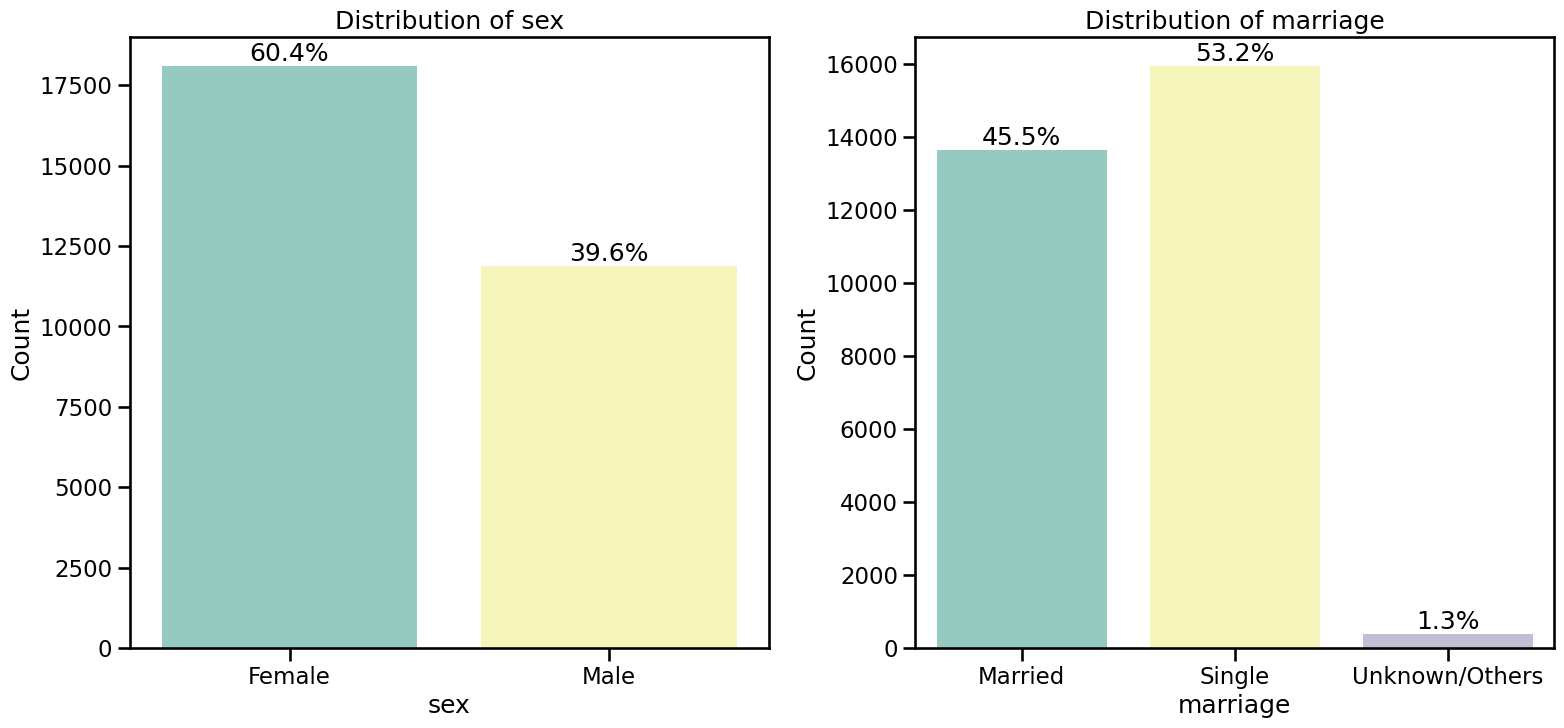

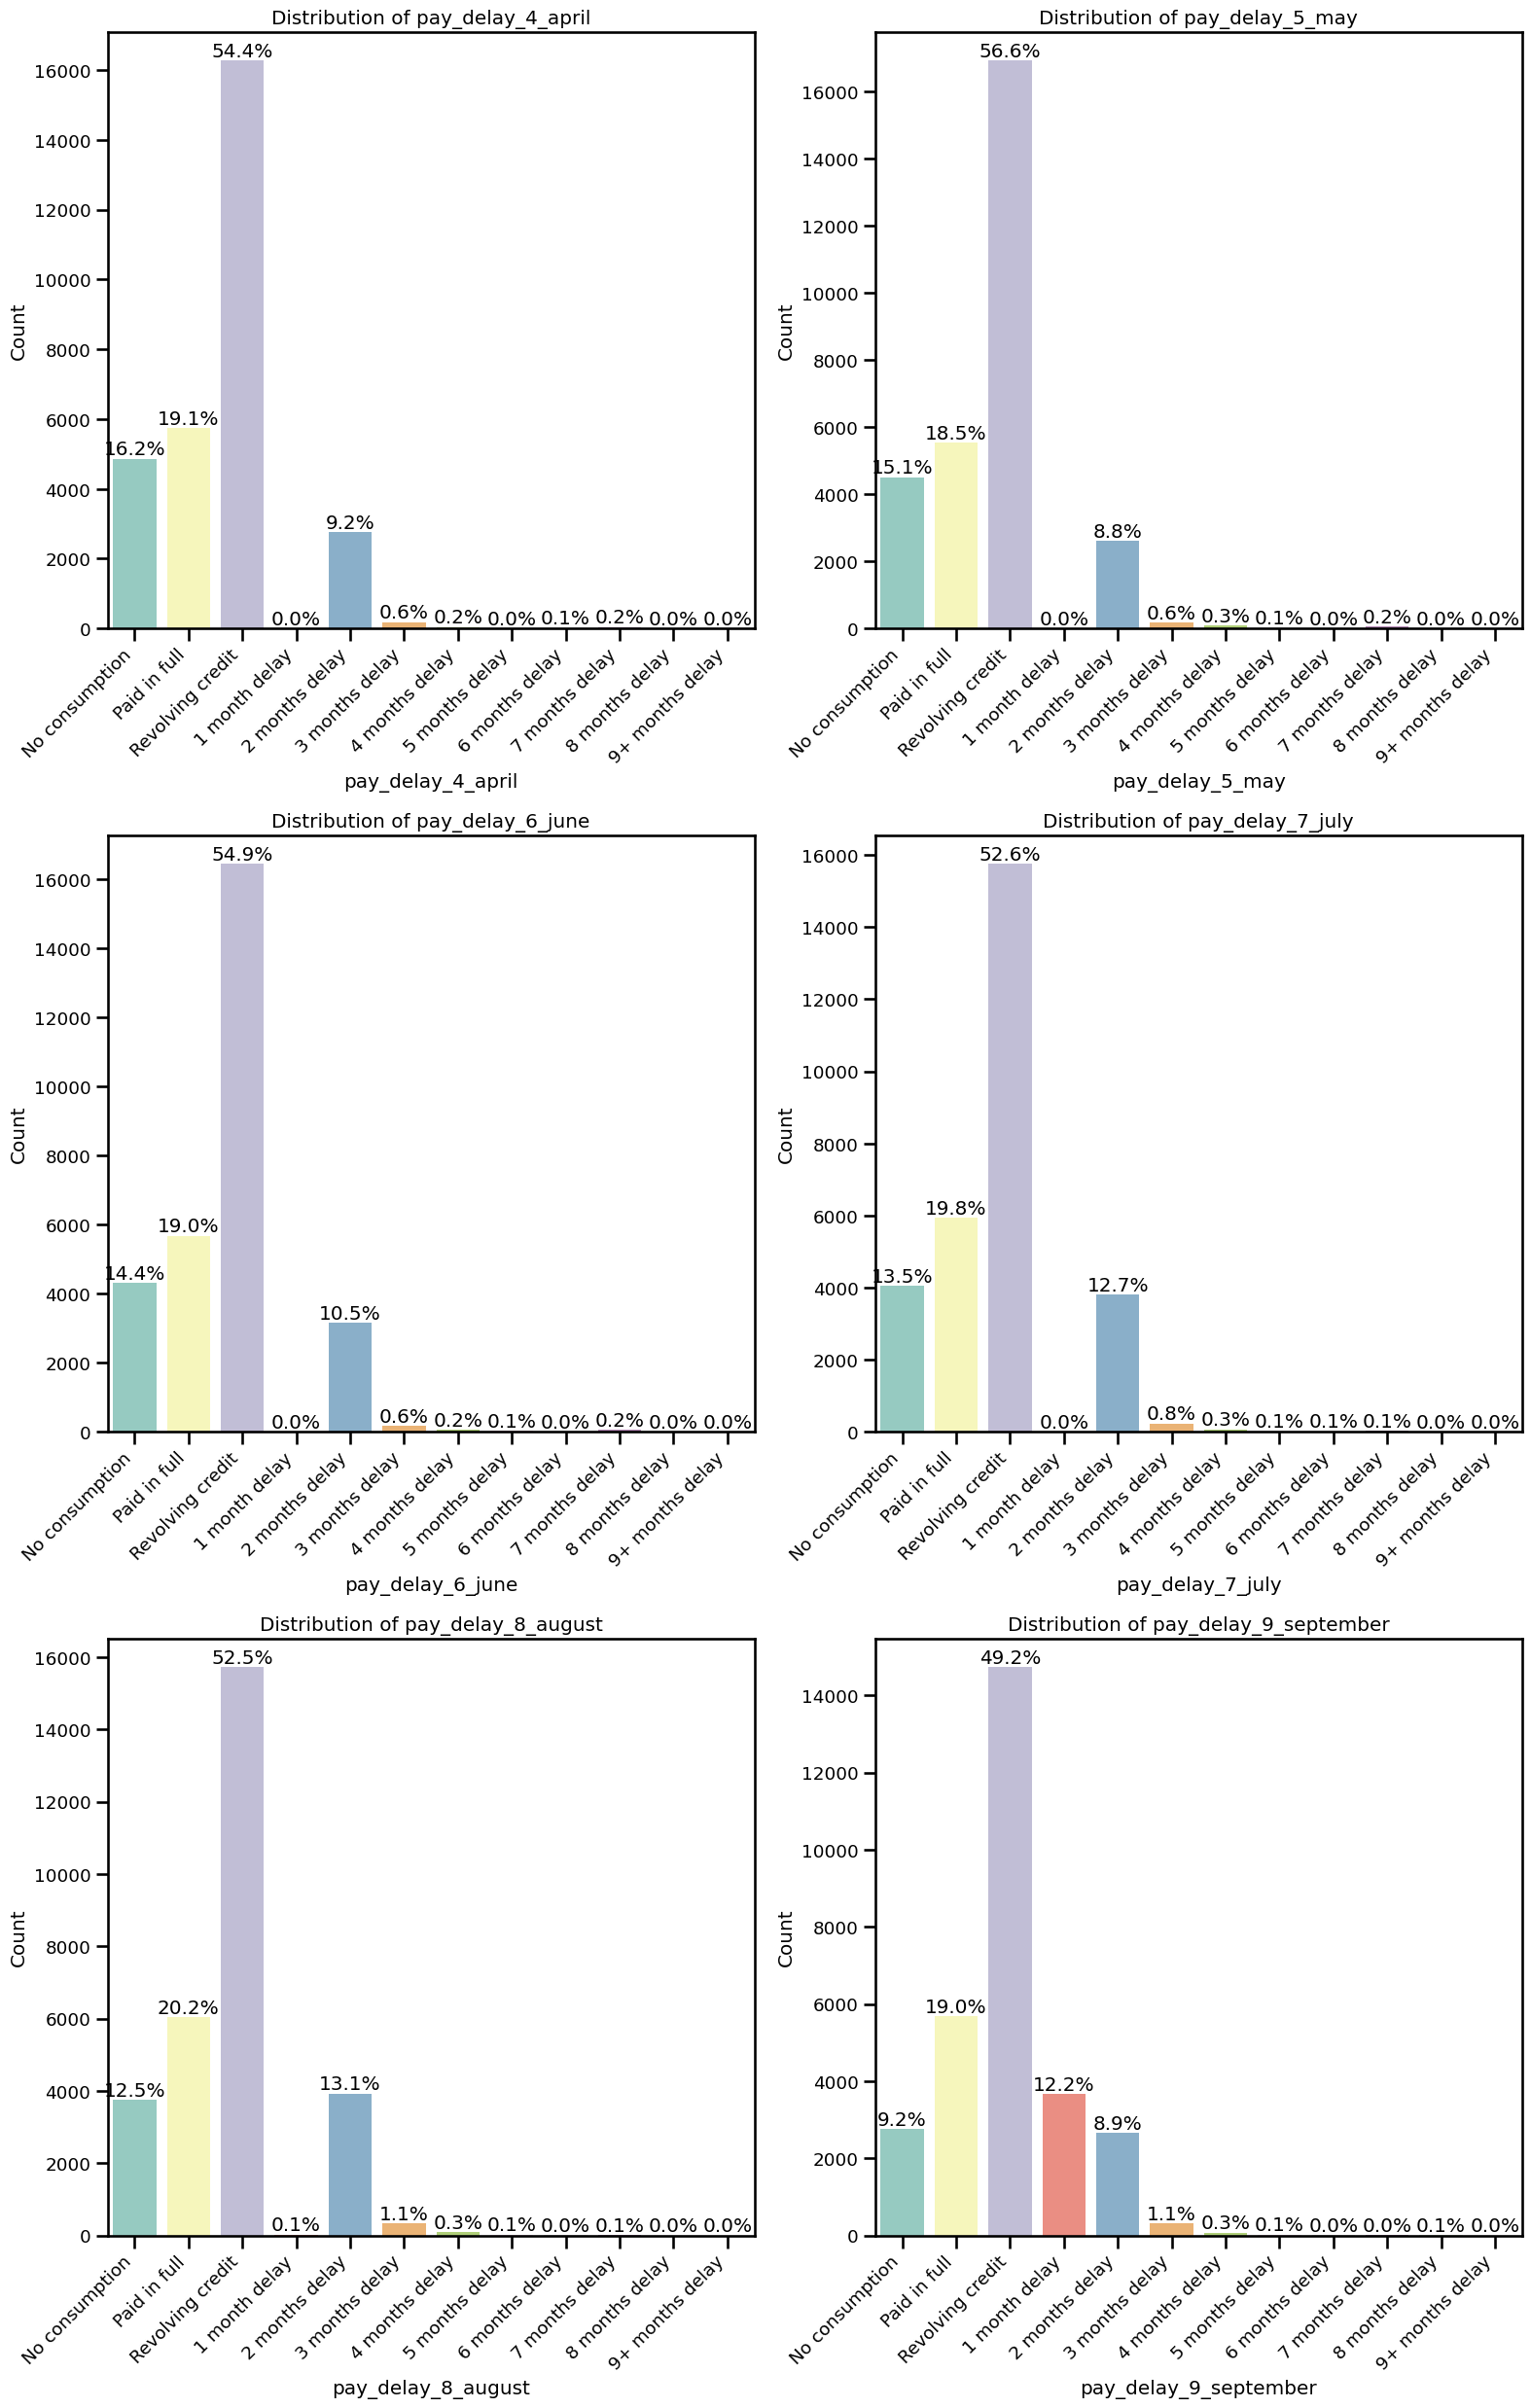

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from loan_data_utils import (load_data_from_url, clean_column_names, remove_id_column, rename_pay_columns, rename_bill_and_payment_columns,load_and_preprocess_data,
                             label_pay_columns, convert_pay_columns_to_ordinal, reorder_columns, convert_education_to_ordinal, process_sex_column, process_sex_column_cat_codes_one_two,
                             process_marriage_column, process_default_payment_column, convert_ordinal_to_category, check_column_integrity, validate_data_types,
                             check_categorical_order, primary_columns, bill_columns, pay_columns, ordinal_columns, categorical_columns,
                             plot_categorical_distributions, plot_ordinal_distributions)
from eda_utils import data_overview, plot_univariate_distributions, plot_class_distribution
import logging

# Define your URL, categorical columns, and target
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'marriage']
target = 'default_payment_next_month'

# Now, load the data
df = load_and_preprocess_data(url, categorical_columns, target)

if df is not None:
    # Ensure the target column is treated as a categorical variable
    df[target] = df[target].astype('category')

    # Print data overview
    data_overview(df)

    # Drop duplicate rows (optional if you didn’t remove them earlier)
    df = df.drop_duplicates()

    # Confirm the duplicates are removed
    print(f"Number of Duplicate Rows After Dropping: {df.duplicated().sum()}")

    # List of columns to check
    pay_cols = [col for col in df.columns if col.startswith('pay_delay')]

    # Check the order of categorical columns
    check_categorical_order(df, categorical_columns + pay_cols + [target])
else:
    print("Error loading and preprocessing data.")

# visualize the categorical data
plot_categorical_distributions(df, categorical_columns)
plot_ordinal_distributions(df, ordinal_columns)

### **Process Categorical Data**

#### Pipeline Processing Limitations:
When using `OneHotEncoder` with `handle_unknown='ignore'`, any unknown categories in the `sex` or `marriage` columns would be encoded as all zeros. This could inadvertently cause the model to interpret unknown values as "female" for `sex` and "married" for `marriage`, potentially leading to misclassification.

#### Category Code Adjustment:
To avoid this, we adjusted the category codes for `sex` and `marriage` to start from `1`, reserving `0` for unknown categories:
- **`sex`**: Male is encoded as `1`, Female as `2`, with unknowns as `0`.
- **`marriage`**: Single is `1`, Married `2`, and Others `3`, with unknowns as `0`.

This adjustment ensures that unknown categories are clearly distinguished from valid categories, improving the robustness of the model.

For ordinal columns where order matters (e.g., education levels), we handle unknowns by assigning them a category of `-1`. This approach maintains clarity and prevents misinterpretation during model training.

### **Target as Category**

### 1. **Compatibility with Machine Learning Models**:
Most machine learning algorithms expect numeric inputs, including for the target variable. By converting the categorical target ('Default', 'No Default') into numeric codes (`0` and `1`), we ensure that the models can process the target data correctly without errors or misinterpretations.

### 2. **Binary Classification**:
In binary classification tasks (like predicting loan defaults), having a target variable in numeric format (`0` for 'Default' and `1` for 'No Default') aligns with standard conventions in machine learning. This format simplifies performance evaluation, especially when calculating metrics such as precision, recall, and F1-score.

### 3. **Simplifies Threshold-based Decisions**:
When implementing custom thresholds for classification, using numeric values (`0` and `1`) allows the use of continuous probability outputs from models, making it easier to adjust and interpret decision thresholds.

### 4. **Avoiding Issues with Category Handling**:
Using categories (such as 'Default' and 'No Default') can introduce complexities during model evaluation, especially when using functions like `classification_report` that expect numeric labels. By converting to numeric codes, we avoid any mismatches or errors when calculating metrics.

### Conclusion:
By converting the categorical target to numeric codes, we ensure better model compatibility, simplify classification tasks, and avoid potential issues during evaluation and threshold adjustment. This step helps to streamline the overall modeling process.

In [4]:
print('Current Cat Codes for Sex:', df['sex'].cat.codes.unique())
print('Current Cat Codes for Marriage:', df['marriage'].cat.codes.unique())

# Adjust category codes manually by adding 1 to the existing codes
df['sex'] = df['sex'].cat.codes + 1
df['marriage'] = df['marriage'].cat.codes + 1

# Recast the adjusted columns back to 'category' dtype with 0 for unknowns
df['sex'] = pd.Categorical(df['sex'], categories=[0, 1, 2], ordered=False)
df['marriage'] = pd.Categorical(df['marriage'], categories=[0, 1, 2, 3], ordered=False)

# Confirm the unique category codes
print('Cat Codes after Recoding - Sex:', df['sex'].cat.codes.unique())  # Output: [1 2]
print('Cat Codes after Recoding - Marriage:', df['marriage'].cat.codes.unique())  # Output: [1 2 3]

print('Target currently categorical')
print(df[target].unique())

df[target] = df[target].cat.codes  # Convert to categorical codes (0, 1)

# Check the results
print('Target converted to numeric')
print(df[target].unique())  # Should output [0, 1]

Current Cat Codes for Sex: [0 1]
Current Cat Codes for Marriage: [0 1 2]
Cat Codes after Recoding - Sex: [1 2]
Cat Codes after Recoding - Marriage: [1 2 3]
Target currently categorical
['Default', 'No Default']
Categories (2, object): ['Default', 'No Default']
Target converted to numeric
[0 1]


## Baseline Model - No Resampling, No Threshold

In [5]:
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from loan_data_utils import ThresholdClassifier, save_classification_reports, save_classification_reports_with_categories
from feature_engineering_pipeline_utils import (HighRiskDelayFeatureTransformer, SevereDelayCountTransformer, CumulativeDelayTransformer,
                                                SevereDelayPaymentRatioTransformer, AvgPaymentSevereDelaysTransformer, DeferredAndDecreasingPaymentsTransformer,
                                                SevereDeferredAndDecreasingPaymentsTransformer, SevereDeferredAndAnyDecreasingPaymentsTransformer,
                                                TotalPaymentsTransformer, AvgPaymentTransformer, PaymentStdTransformer, WeightedPaymentSumTransformer,
                                                TotalBillsTransformer, DebtToLimitRatioTransformer, EducationMarriageInteractionTransformer, WinsorRobustOutlierRemovalTransformer)

# Define the target
target = 'default_payment_next_month'

# Split the data into features and target
X = df.drop(columns=[target])
y = df[target]

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define the columns
numeric_features = ['age', 'limit_bal']
pay_columns = ['pay_amt_4_april', 'pay_amt_5_may',
               'pay_amt_6_june', 'pay_amt_7_july',
               'pay_amt_8_august', 'pay_amt_9_september',
               'bill_amt_4_april', 'bill_amt_5_may',
               'bill_amt_6_june', 'bill_amt_7_july',
               'bill_amt_8_august', 'bill_amt_9_september']
categorical_features = ['sex', 'marriage']
ordinal_features = ['education', 'pay_delay_4_april', 'pay_delay_5_may',
                    'pay_delay_6_june', 'pay_delay_7_july', 'pay_delay_8_august', 'pay_delay_9_september']
delay_columns = ['pay_delay_4_april', 'pay_delay_5_may', 'pay_delay_6_june', 'pay_delay_7_july', 'pay_delay_8_august', 'pay_delay_9_september']
bill_columns = ['bill_amt_4_april', 'bill_amt_5_may', 'bill_amt_6_june', 'bill_amt_7_july', 'bill_amt_8_august', 'bill_amt_9_september']

# Feature Engineering Pipeline
feature_engineering_pipeline = Pipeline(steps=[
    ('high_risk_delay', HighRiskDelayFeatureTransformer(delay_columns=delay_columns)),
    ('severe_delay_count', SevereDelayCountTransformer(delay_columns=delay_columns)),
    ('cumulative_delay', CumulativeDelayTransformer(delay_columns=delay_columns)),
    ('severe_delay_payment_ratio', SevereDelayPaymentRatioTransformer(pay_columns=pay_columns)),
    ('avg_payment_severe_delays', AvgPaymentSevereDelaysTransformer()),
    ('deferred_and_decreasing_payments', DeferredAndDecreasingPaymentsTransformer(delay_columns=delay_columns, pay_columns=pay_columns)),
    ('severe_deferred_and_decreasing_payments', SevereDeferredAndDecreasingPaymentsTransformer(delay_columns=delay_columns, pay_columns=pay_columns)),
    ('severe_deferred_and_any_decreasing_payments', SevereDeferredAndAnyDecreasingPaymentsTransformer(delay_columns=delay_columns, pay_columns=pay_columns)),
    ('total_payments', TotalPaymentsTransformer(pay_columns=pay_columns)),
    ('avg_payment', AvgPaymentTransformer()),
    ('payment_std', PaymentStdTransformer(pay_columns=pay_columns)),
    ('weighted_payment_sum', WeightedPaymentSumTransformer(pay_columns=pay_columns)),
    ('total_bills', TotalBillsTransformer(bill_columns=bill_columns)),  # First create total bills
    ('debt_to_limit_ratio', DebtToLimitRatioTransformer(total_bills_column='total_bills', limit_bal_column='limit_bal')),  # Then create the ratio
    ('education_marriage_interaction', EducationMarriageInteractionTransformer())
])

# Step 1: Outlier Removal Pipeline
outlier_removal_pipeline = Pipeline(steps=[
    ('outlier_removal', WinsorRobustOutlierRemovalTransformer(columns=pay_columns))
])

# Step 2: Preprocessing Pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# We use passthrough here since no transformations are applied to pay_columns before feature engineering
# pay_transformer = 'passthrough'

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        # ('pay', pay_transformer, pay_columns),  # Pass through pay_columns without transformation
        ('cat', categorical_transformer, categorical_features),
        ('ord', ordinal_transformer, ordinal_features)
    ])

# Step 3: Final Pipeline
baseline_pipeline = Pipeline(steps=[
    ('outlier_removal', outlier_removal_pipeline),         # Step 1: Outlier Removal
    ('feature_engineering', feature_engineering_pipeline), # Step 2: Feature Engineering
    ('preprocessor', preprocessor),                        # Step 3: Preprocessing
    ('classifier', LogisticRegression(max_iter=1000))      # Step 4: Model
])

# Train the pipeline
baseline_pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred_baseline = baseline_pipeline.predict(X_test)
classification_report_baseline = classification_report(y_test, y_pred_baseline, output_dict=True)  # Get dict for JSON saving
print("Classification Report (Baseline):")
print(classification_report(y_test, y_pred_baseline))

# Step 3: Save the classification report as 'baseline'
classification_reports = {'baseline': classification_report_baseline}
save_classification_reports(classification_reports, filename='classification_reports.json')


Classification Report (Baseline):
              precision    recall  f1-score   support

           0       0.63      0.28      0.39      1326
           1       0.82      0.95      0.88      4667

    accuracy                           0.80      5993
   macro avg       0.73      0.62      0.63      5993
weighted avg       0.78      0.80      0.77      5993

Classification reports saved as classification_reports.json


## SMOTE Pipeline Model

In [6]:
# Import the necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from imblearn.pipeline import Pipeline as IMBPipeline
from imblearn.over_sampling import SMOTE
from feature_engineering_pipeline_utils import (HighRiskDelayFeatureTransformer, SevereDelayCountTransformer,
                                                CumulativeDelayTransformer, SevereDelayPaymentRatioTransformer,
                                                AvgPaymentSevereDelaysTransformer, DeferredAndDecreasingPaymentsTransformer,
                                                SevereDeferredAndDecreasingPaymentsTransformer, SevereDeferredAndAnyDecreasingPaymentsTransformer,
                                                TotalPaymentsTransformer, AvgPaymentTransformer, PaymentStdTransformer, WeightedPaymentSumTransformer,
                                                TotalBillsTransformer, DebtToLimitRatioTransformer, EducationMarriageInteractionTransformer,
                                                WinsorRobustOutlierRemovalTransformer, CombinedFeatureEngineeringTransformer)

# Define the target
target = 'default_payment_next_month'

# Split the data into features and target
X = df.drop(columns=[target])
y = df[target]

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define the columns (numeric, categorical, ordinal, boolean)
numeric_features = ['age', 'limit_bal', 'bill_amt_4_april', 'bill_amt_5_may', 'bill_amt_6_june',
                    'bill_amt_7_july', 'bill_amt_8_august', 'bill_amt_9_september', 'pay_amt_4_april',
                    'pay_amt_5_may', 'pay_amt_6_june', 'pay_amt_7_july', 'pay_amt_8_august', 'pay_amt_9_september',
                    'severe_delay_count', 'cumulative_delay', 'severe_delay_payment_ratio', 'avg_payment_severe_delays',
                    'total_payments', 'avg_payment', 'payment_std', 'weighted_payment_sum', 'total_bills', 'debt_to_limit_ratio']
pay_columns = ['pay_amt_4_april', 'pay_amt_5_may','pay_amt_6_june', 'pay_amt_7_july','pay_amt_8_august', 'pay_amt_9_september',
               'bill_amt_4_april', 'bill_amt_5_may','bill_amt_6_june', 'bill_amt_7_july','bill_amt_8_august', 'bill_amt_9_september']
delay_columns = ['pay_delay_4_april', 'pay_delay_5_may', 'pay_delay_6_june', 'pay_delay_7_july', 'pay_delay_8_august', 'pay_delay_9_september']
bill_columns = ['bill_amt_4_april', 'bill_amt_5_may', 'bill_amt_6_june', 'bill_amt_7_july', 'bill_amt_8_august', 'bill_amt_9_september']
categorical_features = ['sex', 'marriage', 'education_marriage']
ordinal_features = ['education', 'pay_delay_4_april', 'pay_delay_5_may', 'pay_delay_6_june', 'pay_delay_7_july', 'pay_delay_8_august', 'pay_delay_9_september']
boolean_features = ['high_risk_delay', 'deferred_and_decreasing_payments', 'severe_deferred_and_decreasing_payments', 'severe_deferred_and_any_decreasing_payments']

# Step 1: Feature Engineering and Preprocessing Pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

bool_to_numeric_transformer = Pipeline(steps=[
    ('convert_bool', FunctionTransformer(lambda x: x.astype(int))),
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('ord', ordinal_transformer, ordinal_features),
        ('bool', bool_to_numeric_transformer, boolean_features)
    ]
)

# Step 2: Full Pipeline Setup with Feature Engineering, SMOTE, and Logistic Regression
smote_pipeline = IMBPipeline(steps=[
    ('outlier_removal', WinsorRobustOutlierRemovalTransformer(columns=pay_columns)),  # Outlier removal
    ('feature_engineering', CombinedFeatureEngineeringTransformer(delay_columns, pay_columns, bill_columns)),  # Feature engineering
    ('preprocessor', preprocessor),  # Preprocessing
    ('smote', SMOTE(random_state=42)),  # SMOTE for resampling
    ('classifier', LogisticRegression(max_iter=1000))  # Logistic Regression classifier
])

# Step 4: Train the SMOTE pipeline
smote_pipeline.fit(X_train, y_train)

# Step 5: Predict and generate the SMOTE classification report
y_pred_smote = smote_pipeline.predict(X_test)
classification_report_smote = classification_report(y_test, y_pred_smote, output_dict=True)
print("Classification Report (SMOTE):")
print(classification_report(y_test, y_pred_smote))

# Step 6: Append the SMOTE report to the existing baseline report
with open('classification_reports.json', 'r') as json_file:
    classification_reports = json.load(json_file)

# Add SMOTE report
classification_reports['smote'] = classification_report_smote

# Save the updated reports
save_classification_reports(classification_reports, filename='classification_reports.json')

# Step 6: Print data types after feature engineering
pipeline_outlier_feature_engineering = smote_pipeline.named_steps['feature_engineering']
X_train_after_feature_engineering = pipeline_outlier_feature_engineering.transform(X_train)
X_train_feature_engineering_df = pd.DataFrame(X_train_after_feature_engineering)
print("Data types after feature engineering (train):")
print(X_train_feature_engineering_df.dtypes)

# Step 7: Print data types after preprocessing
pipeline_preprocessing = smote_pipeline.named_steps['preprocessor']
X_train_after_preprocessing = pipeline_preprocessing.transform(X_train_after_feature_engineering)
X_train_preprocessed_df = pd.DataFrame(X_train_after_preprocessing)
print("Data types after preprocessing (train):")
print(X_train_preprocessed_df.dtypes)


Classification Report (SMOTE):
              precision    recall  f1-score   support

           0       0.48      0.60      0.53      1326
           1       0.88      0.82      0.85      4667

    accuracy                           0.77      5993
   macro avg       0.68      0.71      0.69      5993
weighted avg       0.79      0.77      0.78      5993

Classification reports saved as classification_reports.json
Data types after feature engineering (train):
limit_bal                                         int64
sex                                            category
education                                      category
marriage                                       category
age                                               int64
bill_amt_4_april                                  int64
bill_amt_5_may                                    int64
bill_amt_6_june                                   int64
bill_amt_7_july                                   int64
bill_amt_8_august               

### Threshold - Optimal Threshold Selection

#### **Threshold of 0.40 in Context:**

A threshold of **0.40** means the model is more **lenient** in predicting **class 1** (the positive class). It will predict **class 1** whenever the model believes the probability of class 1 is **40% or higher**.

- **Leniency**: Since the threshold is lower than the typical 0.5, the model will **predict class 1 more often**, meaning it will be more likely to predict the positive class even when it’s less certain.
- **Risk of False Positives**: The downside of a lower threshold like 0.40 is that you might see more **false positives**—cases where the model predicts class 1 but it's actually class 0. This could be acceptable in cases where missing a true positive (false negative) is more critical.
- **Application Context**: The suitability of a 0.40 threshold depends on the **specific application**. In cases where **recall** (catching all true positives) is more important than precision, a threshold like 0.40 might be beneficial.

For example, in loan default prediction:
- A lower threshold like 0.40 might be okay if you're more concerned with **catching all potential defaulters** (high recall), even if that means predicting default for some customers who wouldn't actually default (false positives).

### Finding the Optimal Threshold:

To determine the **optimal threshold**, you need to balance the trade-offs between **precision**, **recall**, and other metrics like the **F1-score** (which balances both precision and recall).

Here’s how you typically determine the **optimal threshold**:

1. **Metric Selection**:
   - Choose what matters most to you. For example:
     - **Recall**: If it's critical to catch all positives (e.g., in medical diagnosis).
     - **Precision**: If you care more about being sure that a positive prediction is truly positive (e.g., in fraud detection).
     - **F1 Score**: If you want a balance between precision and recall.

2. **Threshold Tuning Process**:
   - **Run the model** at different thresholds (as you’ve already done, which is great).
   - For each threshold (e.g., 0.1, 0.2, 0.3, …, 0.9), **calculate key metrics** like precision, recall, and F1-score.
   - **Plot these metrics** against the thresholds to visually inspect which threshold gives you the best performance according to your priorities.

3. **Determine the Best Trade-off**:
   - For instance, if you value **recall** and want to ensure you catch as many true positives as possible, you might choose a **lower threshold** (e.g., 0.40).
   - If you value **precision** and want to be sure your positive predictions are correct, you might select a **higher threshold** (e.g., 0.70 or 0.80).
   - If you want a balance between the two, look at the **F1-score** or other metrics that give you a combined view of precision and recall.

### Example of Threshold Optimization Process:

1. **Set a Range of Thresholds**: Test thresholds between 0.1 and 0.9 (e.g., `np.arange(0.1, 1.0, 0.1)`).
2. **Calculate Metrics**: For each threshold, calculate precision, recall, and F1.
3. **Plot the Results**: Plot precision, recall, and F1 against the thresholds to identify where you get the best trade-off. This will help you visually understand which threshold gives you the best performance according to your metric priorities.

Here’s a **simple guide**:
- **Low threshold (e.g., 0.3)**: High recall, lower precision.
- **High threshold (e.g., 0.8)**: High precision, lower recall.
- **Moderate threshold (e.g., 0.5)**: Balanced precision and recall.

### Conclusion:
- **0.40** might be on the lower side, but it depends on your problem. If you’re more concerned with **catching as many true positives as possible**, it might be a good fit.
- The **optimal threshold** depends on balancing your desired metrics (precision, recall, F1-score). The threshold at which these metrics align with your goals is what you consider **optimal**.

By plotting precision, recall, and F1-score at various thresholds, you can visually and analytically determine the optimal value.

In [8]:
# Define a range of thresholds to test
threshold_values = np.arange(0.1, 1.0, 0.1)

# Lists to store metrics for plotting
recall_scores = []
precision_scores = []
f1_macro_scores = []

# Iterate through each threshold value
for threshold in threshold_values:
    print(f"Testing threshold: {threshold}")

    # Create the logistic regression model
    log_reg = LogisticRegression(max_iter=1000)

    # Wrap the model with ThresholdClassifier using the current threshold
    threshold_classifier = ThresholdClassifier(base_classifier=log_reg, threshold=threshold)

    # Step 3: Pipeline Setup with ThresholdClassifier
    smote_pipeline = IMBPipeline(steps=[
        ('outlier_removal', WinsorRobustOutlierRemovalTransformer(columns=pay_columns)),
        ('feature_engineering', CombinedFeatureEngineeringTransformer(delay_columns, pay_columns, bill_columns)),
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', threshold_classifier)  # Use threshold classifier
    ])

    # Step 4: Train the pipeline
    smote_pipeline.fit(X_train, y_train)

    # Step 5: Predict using the threshold classifier and generate the classification report
    y_pred = smote_pipeline.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)  # Use y_test directly

    # Store Class 1 recall, precision, and F1-macro score for the current threshold
    recall_scores.append(report['1']['recall'])
    precision_scores.append(report['1']['precision'])
    f1_macro_scores.append(report['macro avg']['f1-score'])

# After the loop, print or plot the metrics for each threshold
print("Thresholds:", threshold_values)
print("Recall scores:", recall_scores)
print("Precision scores:", precision_scores)
print("F1-macro scores:", f1_macro_scores)


Testing threshold: 0.1
Testing threshold: 0.2
Testing threshold: 0.30000000000000004
Testing threshold: 0.4
Testing threshold: 0.5
Testing threshold: 0.6
Testing threshold: 0.7000000000000001
Testing threshold: 0.8
Testing threshold: 0.9
Thresholds: [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
Recall scores: [0.9873580458538675, 0.9584315406042425, 0.9170773516177416, 0.8658667238054425, 0.8174416113134776, 0.6245982429826441, 0.3130490679237197, 0.13606170987786587, 0.028712234840368545]
Precision scores: [0.7986135181975736, 0.8252767527675277, 0.8507255018882925, 0.8667953667953668, 0.876809928752011, 0.893349678210236, 0.9165621079046424, 0.9256559766763849, 0.9640287769784173]
F1-macro scores: [0.5473809378450915, 0.6430207797741534, 0.6926392976996194, 0.6985022442875952, 0.6892153100208687, 0.6087156853235037, 0.4417335846987904, 0.31084578466294954, 0.2118651013067463]


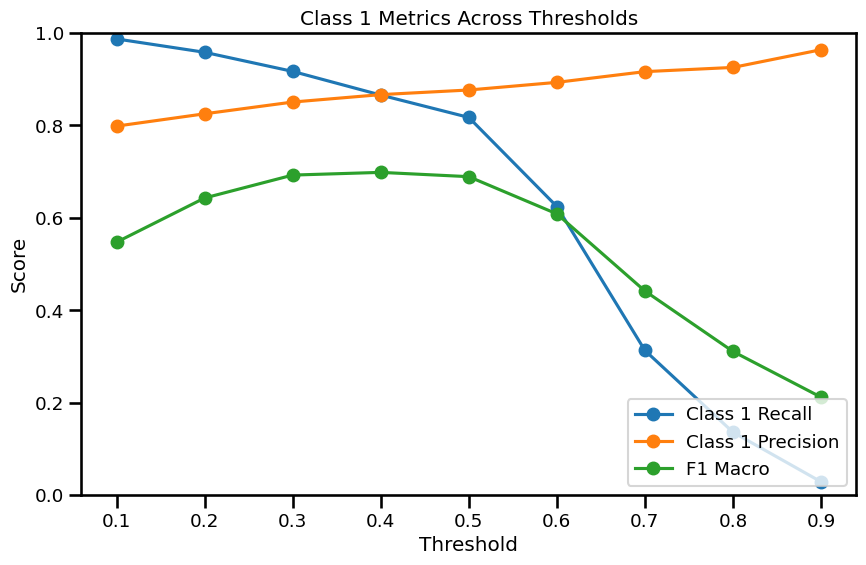

In [9]:
# Plotting the metrics
plt.figure(figsize=(10, 6))
plt.plot(threshold_values, recall_scores, label="Class 1 Recall", marker='o')
plt.plot(threshold_values, precision_scores, label="Class 1 Precision", marker='o')
plt.plot(threshold_values, f1_macro_scores, label="F1 Macro", marker='o')

# Plot labels and title
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Class 1 Metrics Across Thresholds")
plt.ylim(0, 1)
plt.legend(loc='lower right')

# Show the plot
plt.show()

## SMOTE Model with Optimal Threshold

In [20]:
# Import the necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from imblearn.pipeline import Pipeline as IMBPipeline
from imblearn.over_sampling import SMOTE
from loan_data_utils import ThresholdClassifier
from feature_engineering_pipeline_utils import (HighRiskDelayFeatureTransformer, SevereDelayCountTransformer,
                                                CumulativeDelayTransformer, SevereDelayPaymentRatioTransformer,
                                                AvgPaymentSevereDelaysTransformer, DeferredAndDecreasingPaymentsTransformer,
                                                SevereDeferredAndDecreasingPaymentsTransformer, SevereDeferredAndAnyDecreasingPaymentsTransformer,
                                                TotalPaymentsTransformer, AvgPaymentTransformer, PaymentStdTransformer, WeightedPaymentSumTransformer,
                                                TotalBillsTransformer, DebtToLimitRatioTransformer, EducationMarriageInteractionTransformer,
                                                WinsorRobustOutlierRemovalTransformer, CombinedFeatureEngineeringTransformer)

# Define the target
target = 'default_payment_next_month'

# Split the data into features and target
X = df.drop(columns=[target])
y = df[target]

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define the columns (numeric, categorical, ordinal, boolean)
numeric_features = ['age', 'limit_bal', 'bill_amt_4_april', 'bill_amt_5_may', 'bill_amt_6_june',
                    'bill_amt_7_july', 'bill_amt_8_august', 'bill_amt_9_september', 'pay_amt_4_april',
                    'pay_amt_5_may', 'pay_amt_6_june', 'pay_amt_7_july', 'pay_amt_8_august', 'pay_amt_9_september',
                    'severe_delay_count', 'cumulative_delay', 'severe_delay_payment_ratio', 'avg_payment_severe_delays',
                    'total_payments', 'avg_payment', 'payment_std', 'weighted_payment_sum', 'total_bills', 'debt_to_limit_ratio']
pay_columns = ['pay_amt_4_april', 'pay_amt_5_may','pay_amt_6_june', 'pay_amt_7_july','pay_amt_8_august', 'pay_amt_9_september',
               'bill_amt_4_april', 'bill_amt_5_may','bill_amt_6_june', 'bill_amt_7_july','bill_amt_8_august', 'bill_amt_9_september']
delay_columns = ['pay_delay_4_april', 'pay_delay_5_may', 'pay_delay_6_june', 'pay_delay_7_july', 'pay_delay_8_august', 'pay_delay_9_september']
bill_columns = ['bill_amt_4_april', 'bill_amt_5_may', 'bill_amt_6_june', 'bill_amt_7_july', 'bill_amt_8_august', 'bill_amt_9_september']
categorical_features = ['sex', 'marriage', 'education_marriage']
ordinal_features = ['education', 'pay_delay_4_april', 'pay_delay_5_may', 'pay_delay_6_june', 'pay_delay_7_july', 'pay_delay_8_august', 'pay_delay_9_september']
boolean_features = ['high_risk_delay', 'deferred_and_decreasing_payments', 'severe_deferred_and_decreasing_payments', 'severe_deferred_and_any_decreasing_payments']

# Step 1: Feature Engineering and Preprocessing Pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

bool_to_numeric_transformer = Pipeline(steps=[
    ('convert_bool', FunctionTransformer(lambda x: x.astype(int))),
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('ord', ordinal_transformer, ordinal_features),
        ('bool', bool_to_numeric_transformer, boolean_features)
    ]
)

# Create the logistic regression model
log_reg = LogisticRegression(max_iter=1000)
# Wrap the model with ThresholdClassifier using the custom threshold
threshold_classifier = ThresholdClassifier(base_classifier=log_reg, threshold=0.4)

# Pipeline setup with ThresholdClassifier
smote_threshold_pipeline = IMBPipeline(steps=[
    ('outlier_removal', WinsorRobustOutlierRemovalTransformer(columns=pay_columns)),
    ('feature_engineering', CombinedFeatureEngineeringTransformer(delay_columns, pay_columns, bill_columns)),
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', threshold_classifier)  # Use the custom threshold classifier
])

# Train the pipeline
smote_threshold_pipeline.fit(X_train, y_train)

# Predict and generate the SMOTE classification report with custom threshold
y_pred_threshold = smote_threshold_pipeline.predict(X_test)
classification_report_threshold = classification_report(y_test, y_pred_threshold, output_dict=True)
print("Classification Report (SMOTE with Custom Threshold):")
print(classification_report(y_test, y_pred_threshold))

# Append the new classification report for the optimal threshold
# Load existing classification reports
with open('classification_reports.json', 'r') as json_file:
    classification_reports = json.load(json_file)

# Add the SMOTE threshold report
classification_reports['smote_threshold_optimal'] = classification_report_threshold

# Save the updated reports
save_classification_reports(classification_reports, filename='classification_reports.json')

Classification Report (SMOTE with Custom Threshold):
              precision    recall  f1-score   support

           0       0.53      0.53      0.53      1326
           1       0.87      0.87      0.87      4667

    accuracy                           0.79      5993
   macro avg       0.70      0.70      0.70      5993
weighted avg       0.79      0.79      0.79      5993

Classification reports saved as classification_reports.json


### Model Comparison - Visualizations

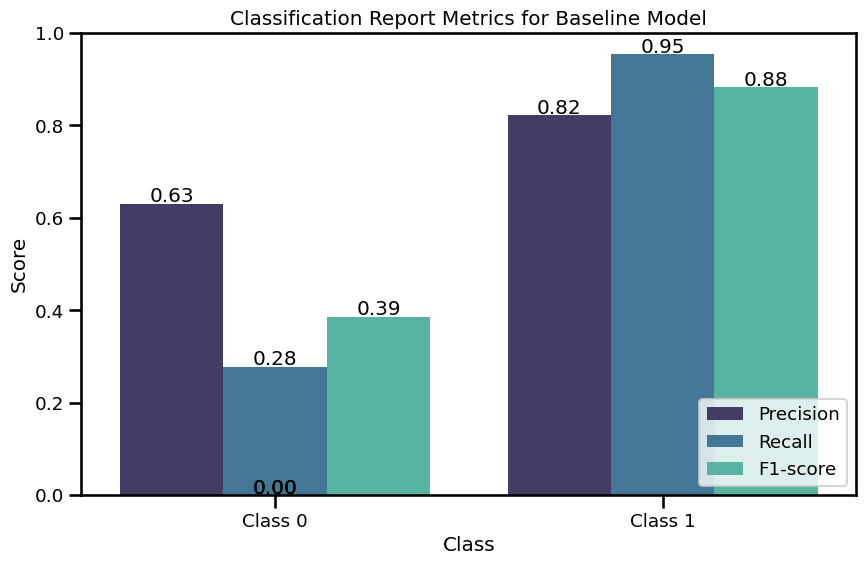

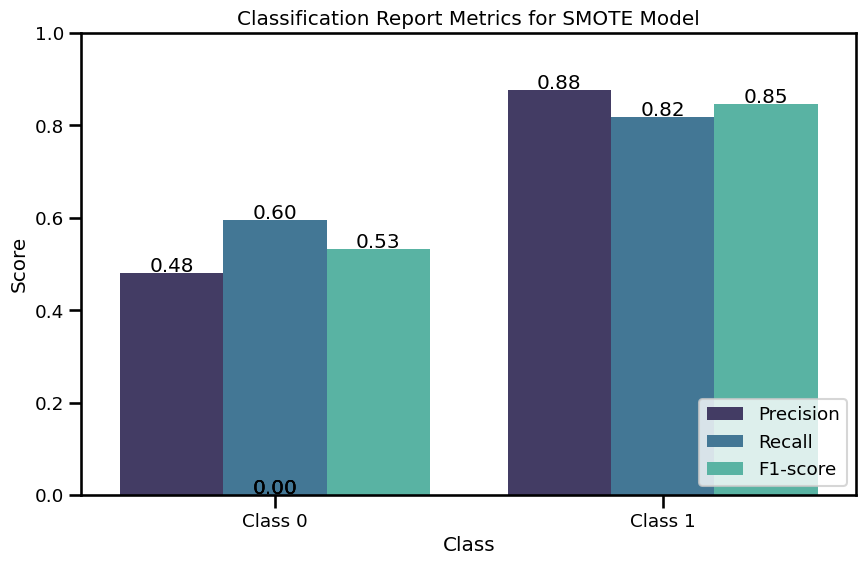

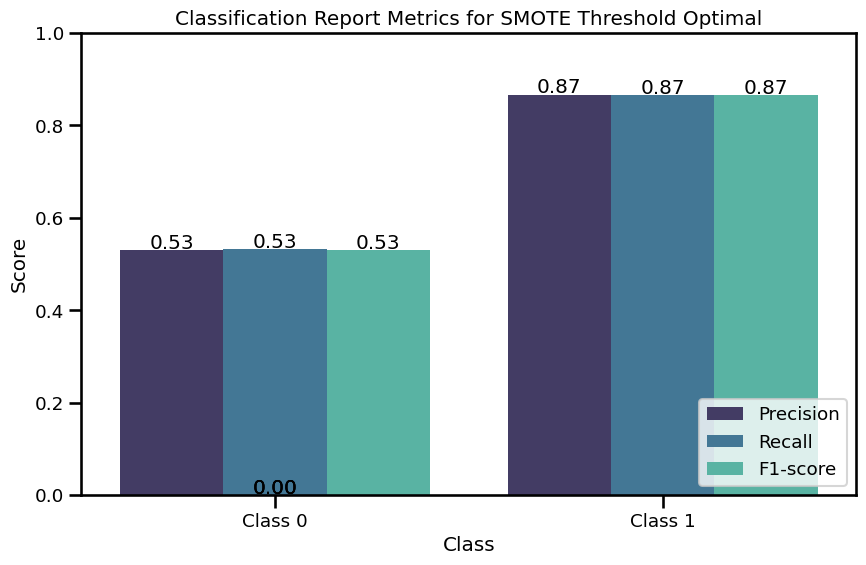

In [12]:
from loan_data_utils import plot_classification_report_metrics

# Step 1: Load the classification reports from the JSON file
with open('classification_reports.json', 'r') as json_file:
    classification_reports = json.load(json_file)

# Step 2: Plot the metrics for the baseline model
plot_classification_report_metrics(classification_reports['baseline'], 'Baseline Model')
# Step 3: Plot the metrics for the SMOTE-enhanced model
plot_classification_report_metrics(classification_reports['smote'], 'SMOTE Model')
# Step 4: Plot the metrics for the SMOTE Optimal Threshold model
plot_classification_report_metrics(classification_reports['smote_threshold_optimal'], 'SMOTE Threshold Optimal')


In [13]:
import json
import pandas as pd

# Function to load and process numeric classification reports
def load_numeric_reports(json_filename):
    # Load the classification reports from the JSON file
    with open(json_filename, 'r') as json_file:
        classification_reports = json.load(json_file)

    # Extract relevant metrics from the report (class 0 and 1 correspond to 'No Default' and 'Default')
    def extract_metrics(report, model_name):
        data = {
            'Model': model_name,
            'Class No Default Precision': report['0']['precision'],
            'Class No Default Recall': report['0']['recall'],
            'Class No Default F1-score': report['0']['f1-score'],
            'Class Default Precision': report['1']['precision'],
            'Class Default Recall': report['1']['recall'],
            'Class Default F1-score': report['1']['f1-score'],
            'Accuracy': report['accuracy'],
            'Macro Avg Precision': report['macro avg']['precision'],
            'Macro Avg Recall': report['macro avg']['recall'],
            'Macro Avg F1-score': report['macro avg']['f1-score']
        }
        return data

    # Create a DataFrame from the classification reports
    reports_data = []
    for model_name, report in classification_reports.items():
        reports_data.append(extract_metrics(report, model_name))

    # Convert the list of dictionaries into a DataFrame
    df_numeric = pd.DataFrame(reports_data)
    return df_numeric

# Load the reports
df_reports = load_numeric_reports('classification_reports.json')
df_reports

,Model,Class No Default Precision,Class No Default Recall,Class No Default F1-score,Class Default Precision,Class Default Recall,Class Default F1-score,Accuracy,Macro Avg Precision,Macro Avg Recall,Macro Avg F1-score
0,baseline,0.630769,0.278281,0.386185,0.823040,0.953718,0.883573,0.804272,0.726905,0.615999,0.634879
1,smote,0.481121,0.595777,0.532345,0.876810,0.817442,0.846086,0.768396,0.678965,0.706609,0.689215
2,smote_threshold_optimal,0.529677,0.531674,0.530674,0.866795,0.865867,0.866331,0.791924,0.698236,0.698770,0.698502


### Model Comparison Summary:

#### 1. **Baseline Model**:
The baseline model performs well for predicting **loan defaults** (class 1), with high precision (82%) and very high recall (95%), meaning it catches most actual defaults. However, it struggles significantly with **no default** predictions (class 0), achieving low precision (63%) and very poor recall (28%). This leads to a biased model that is good at identifying defaults but fails to identify **no defaults** accurately.

#### 2. **SMOTE Model**:
Applying **SMOTE** improves the model’s ability to predict **no defaults**. The recall for class 0 jumps from 28% to 60%, meaning the model catches far more **no defaults**. However, this comes at the cost of some precision for class 1, as the precision drops slightly from 82% to 88%. Despite the lower accuracy (76.8%), the **SMOTE model** is more balanced between classes, making it a more reliable choice when predicting **no defaults** is important.

#### 3. **SMOTE with Optimal Threshold**:
The **SMOTE with Optimal Threshold** model strikes the best balance between the two classes. The recall and precision for both **no default** and **default** predictions are nearly identical, making this the most consistent model across both categories. While class 0 recall (53%) isn’t as high as in the SMOTE model, it’s a significant improvement over the baseline. Class 1 recall remains strong at 87%, and the overall **F1-score** and **accuracy** improve slightly over the SMOTE model.

### Conclusion & Recommendations:
- **Baseline**: This model is overly focused on predicting **defaults** while ignoring many **no defaults**, making it unbalanced and less suitable for real-world scenarios where predicting **no defaults** is equally important.
  
- **SMOTE**: This model improves the recall for **no defaults**, meaning it identifies more **no defaults** at the expense of some precision. It’s a better choice than the baseline when more balanced predictions are needed, but the drop in precision might not be ideal in some applications.
  
- **SMOTE with Optimal Threshold**: This model provides the best overall performance by balancing recall and precision for both **defaults** and **no defaults**. The **optimal threshold** allows the model to make better trade-offs between precision and recall, leading to a more reliable model for both classes. This would be the recommended model as it offers the best compromise between accuracy and class-specific performance, making it more robust and applicable to real-world use cases where balanced predictions are essential.

### Model Stability

The **SMOTE with Optimal Threshold** model is much more **stable** in its predictions. This stability is reflected in the almost equal precision, recall, and F1-scores for both the **no default** and **default** classes. Here's what this stability implies:

### 1. **Balanced Performance Across Classes**:
   - The model doesn't overly favor one class over the other. In many classification problems (especially with imbalanced data like loan defaults), models can often perform well for one class (usually the majority class) at the expense of the other. In this case, the **SMOTE with Optimal Threshold** model maintains a consistent balance between both classes, with precision and recall being very similar for both **default** and **no default**.
   
### 2. **Less Sensitivity to Threshold Adjustments**:
   - The model is less sensitive to changes in the decision threshold, which means its performance remains steady even when adjusting the threshold. This implies that the model makes **strong, reliable predictions**, and small changes in the threshold won’t cause dramatic swings in precision or recall. This is particularly valuable in applications where decision-making needs to be consistent over time.

### 3. **Robustness**:
   - This stability implies the model can generalize better to new data. It's less likely to overfit to one class and will likely perform well in real-world situations, where the distribution of classes can vary or shift over time.

### 4. **Practical Implications**:
   - In practice, a **more stable model** means you can trust its predictions to be reliable in both identifying loan defaults and accurately catching no defaults. It can handle the real-world nuances of class imbalance better, without overcompensating for either class.
   - The decision-makers (e.g., risk managers, financial institutions) can rely on this model for more consistent, interpretable results, which is crucial for operationalizing the model in production environments.

### Conclusion:
The **SMOTE with Optimal Threshold** model's stability indicates a strong ability to balance between recall and precision, leading to **more consistent and robust predictions**. This would be the preferred model, particularly when **both classes are important** and you need a model that can generalize well to unseen data.

### Threshold 0.2 Model Test

In [24]:
# Import the necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from imblearn.pipeline import Pipeline as IMBPipeline
from imblearn.over_sampling import SMOTE
from loan_data_utils import ThresholdClassifier
from feature_engineering_pipeline_utils import (HighRiskDelayFeatureTransformer, SevereDelayCountTransformer,
                                                CumulativeDelayTransformer, SevereDelayPaymentRatioTransformer,
                                                AvgPaymentSevereDelaysTransformer, DeferredAndDecreasingPaymentsTransformer,
                                                SevereDeferredAndDecreasingPaymentsTransformer, SevereDeferredAndAnyDecreasingPaymentsTransformer,
                                                TotalPaymentsTransformer, AvgPaymentTransformer, PaymentStdTransformer, WeightedPaymentSumTransformer,
                                                TotalBillsTransformer, DebtToLimitRatioTransformer, EducationMarriageInteractionTransformer,
                                                WinsorRobustOutlierRemovalTransformer, CombinedFeatureEngineeringTransformer)

# Define the target
target = 'default_payment_next_month'

# Split the data into features and target
X = df.drop(columns=[target])
y = df[target]

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define the columns (numeric, categorical, ordinal, boolean)
numeric_features = ['age', 'limit_bal', 'bill_amt_4_april', 'bill_amt_5_may', 'bill_amt_6_june',
                    'bill_amt_7_july', 'bill_amt_8_august', 'bill_amt_9_september', 'pay_amt_4_april',
                    'pay_amt_5_may', 'pay_amt_6_june', 'pay_amt_7_july', 'pay_amt_8_august', 'pay_amt_9_september',
                    'severe_delay_count', 'cumulative_delay', 'severe_delay_payment_ratio', 'avg_payment_severe_delays',
                    'total_payments', 'avg_payment', 'payment_std', 'weighted_payment_sum', 'total_bills', 'debt_to_limit_ratio']
pay_columns = ['pay_amt_4_april', 'pay_amt_5_may','pay_amt_6_june', 'pay_amt_7_july','pay_amt_8_august', 'pay_amt_9_september',
               'bill_amt_4_april', 'bill_amt_5_may','bill_amt_6_june', 'bill_amt_7_july','bill_amt_8_august', 'bill_amt_9_september']
delay_columns = ['pay_delay_4_april', 'pay_delay_5_may', 'pay_delay_6_june', 'pay_delay_7_july', 'pay_delay_8_august', 'pay_delay_9_september']
bill_columns = ['bill_amt_4_april', 'bill_amt_5_may', 'bill_amt_6_june', 'bill_amt_7_july', 'bill_amt_8_august', 'bill_amt_9_september']
categorical_features = ['sex', 'marriage', 'education_marriage']
ordinal_features = ['education', 'pay_delay_4_april', 'pay_delay_5_may', 'pay_delay_6_june', 'pay_delay_7_july', 'pay_delay_8_august', 'pay_delay_9_september']
boolean_features = ['high_risk_delay', 'deferred_and_decreasing_payments', 'severe_deferred_and_decreasing_payments', 'severe_deferred_and_any_decreasing_payments']

# Step 1: Feature Engineering and Preprocessing Pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

bool_to_numeric_transformer = Pipeline(steps=[
    ('convert_bool', FunctionTransformer(lambda x: x.astype(int))),
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('ord', ordinal_transformer, ordinal_features),
        ('bool', bool_to_numeric_transformer, boolean_features)
    ]
)

# Create the logistic regression model
log_reg = LogisticRegression(max_iter=1000)
# Wrap the model with ThresholdClassifier using the custom threshold
threshold_classifier_20 = ThresholdClassifier(base_classifier=log_reg, threshold=0.2)

# Pipeline setup with ThresholdClassifier (0.20 threshold)
smote_threshold_pipeline_20 = IMBPipeline(steps=[
    ('outlier_removal', WinsorRobustOutlierRemovalTransformer(columns=pay_columns)),
    ('feature_engineering', CombinedFeatureEngineeringTransformer(delay_columns, pay_columns, bill_columns)),
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', threshold_classifier_20)  # Use the custom threshold classifier with 0.20
])

# Train the pipeline
smote_threshold_pipeline_20.fit(X_train, y_train)

# Predict and generate the classification report with the 0.20 threshold
y_pred_threshold_20 = smote_threshold_pipeline_20.predict(X_test)
classification_report_threshold_20 = classification_report(y_test, y_pred_threshold_20, output_dict=True)

print("Classification Report (SMOTE with 0.20 Threshold):")
print(classification_report(y_test, y_pred_threshold_20))

# Append the new classification report for the 0.20 threshold
# Load existing classification reports
with open('classification_reports.json', 'r') as json_file:
    classification_reports = json.load(json_file)

# Add the SMOTE threshold 0.20 report
classification_reports['smote_threshold_0_20'] = classification_report_threshold_20

# Save the updated reports
with open('classification_reports.json', 'w') as json_file:
    json.dump(classification_reports, json_file)


Classification Report (SMOTE with 0.20 Threshold):
              precision    recall  f1-score   support

           0       0.66      0.29      0.40      1326
           1       0.83      0.96      0.89      4667

    accuracy                           0.81      5993
   macro avg       0.74      0.62      0.64      5993
weighted avg       0.79      0.81      0.78      5993



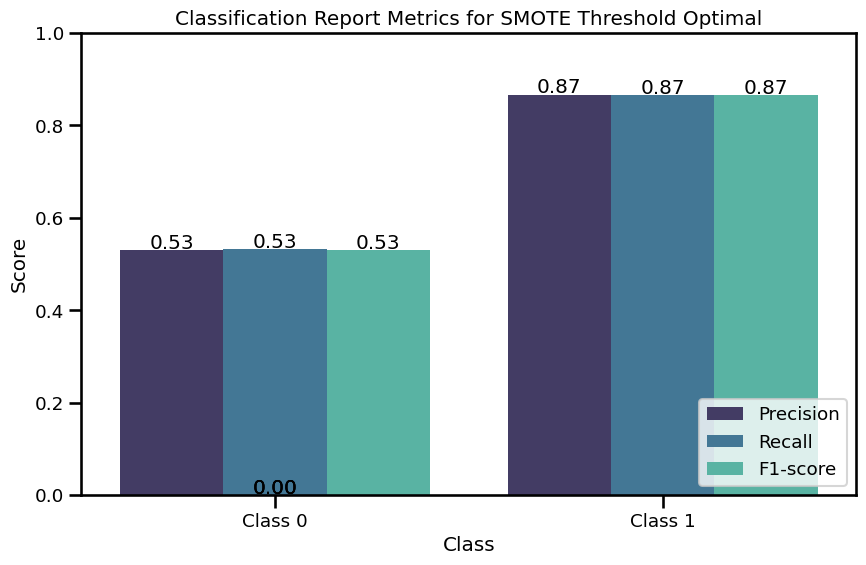

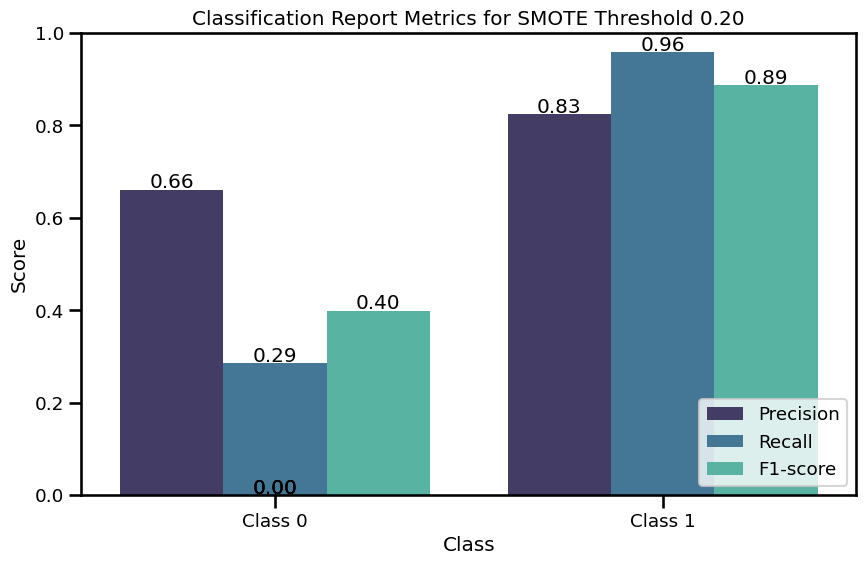

In [25]:
plot_classification_report_metrics(classification_reports['smote_threshold_optimal'], 'SMOTE Threshold Optimal')
plot_classification_report_metrics(classification_reports['smote_threshold_0_20'], 'SMOTE Threshold 0.20')


#### Loan Data Utils

In [14]:
script_content=r'''
# loan_data_utils.py

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import logging
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin

import json

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

target = 'default_payment_next_month'
# Define primary, bill, and pay columns
primary_columns = ['limit_bal', 'sex', 'education', 'marriage', 'age']
bill_columns = ['bill_amt_4_april', 'bill_amt_5_may', 'bill_amt_6_june', 'bill_amt_7_july', 'bill_amt_8_august', 'bill_amt_9_september']
pay_columns = ['pay_amt_4_april', 'pay_amt_5_may', 'pay_amt_6_june', 'pay_amt_7_july', 'pay_amt_8_august', 'pay_amt_9_september']
ordinal_columns = ['education', 'pay_delay_9_september', 'pay_delay_8_august', 'pay_delay_7_july', 'pay_delay_6_june', 'pay_delay_5_may', 'pay_delay_4_april']

def load_data_from_url(url):
    try:
        df = pd.read_excel(url, header=1)
        logging.info("Data loaded successfully from URL.")
    except Exception as e:
        logging.error(f"Error loading data from URL: {e}")
        return None
    return df

def split_features_target(df, target):
    try:
        X = df.drop(columns=[target])
        y = df[target]
        logging.info("Features and target split successfully.")
    except Exception as e:
        logging.error(f"Error splitting features and target: {e}")
        return None, None
    return X, y


def clean_column_names(df):
    try:
        df.columns = [col.lower().replace(' ', '_') for col in df.columns]
        logging.info("Column names cleaned successfully.")
    except Exception as e:
        logging.error(f"Error cleaning column names: {e}")
    return df

def remove_id_column(df):
    if 'id' in df.columns:
        df = df.drop(columns=['id'])
        logging.info("ID column removed.")
    return df

# ---------  Sex Column Processing  --------- #
# ---- SEX: Gender (1 = male, 2 = female) ----#

# results in cat.categories = ['Female', 'Male'][0,1]
def process_sex_column(df):
    try:
        if 'sex' in df.columns:
            df['sex'] = df['sex'].replace({1: 'Male', 2: 'Female'})
            df['sex'] = df['sex'].astype('category')
            logging.info("Sex column processed and converted to categorical successfully.")
        else:
            logging.warning("Sex column not found in DataFrame.")
    except Exception as e:
        logging.error(f"Error processing sex column: {e}")
    return df

# results in cat.categories = ['Female', 'Male'][2,1] (alphabetically ordered)
def process_sex_column_cat_codes_one_two(df):
    try:
        if 'sex' in df.columns:
            # Convert numeric values to categorical, maintaining original codes
            df['sex'] = df['sex'].astype('category')  # First, ensure the column is categorical

            # Define the categories explicitly and map original values (1: Male, 2: Female)
            df['sex'].cat.set_categories([1, 2], rename=True, inplace=True)  # Set categories as 1, 2
            df['sex'] = df['sex'].replace({1: 'Male', 2: 'Female'})  # Replace numeric values with labels

            logging.info("Sex column processed and converted to categorical successfully.")
        else:
            logging.warning("Sex column not found in DataFrame.")
    except Exception as e:
        logging.error(f"Error processing sex column: {e}")
    return df

# ---------  Marriage Column Processing  --------- #

# ---- MARRIAGE: Marital status (1 = married, 2 = single, 3 = other) ----#

def process_marriage_column(df):
    try:
        if 'marriage' in df.columns:
            df['marriage'] = df['marriage'].replace({0: 'Unknown/Others', 3: 'Unknown/Others'})
            df['marriage'] = df['marriage'].replace({1: 'Married', 2: 'Single'})
            df['marriage'] = pd.Categorical(df['marriage'], categories=['Married', 'Single', 'Unknown/Others'], ordered=False)
            logging.info("Marriage column processed and converted to categorical successfully.")
        else:
            logging.warning("Marriage column not found in DataFrame.")
    except Exception as e:
        logging.error(f"Error processing marriage column: {e}")
    return df

# ---------  Target Column Processing  --------- #

def process_default_payment_column(df):
    try:
        if 'default_payment_next_month' in df.columns:
            # Convert 0 and 1 to categorical values
            df['default_payment_next_month'] = df['default_payment_next_month'].astype('category')
            logging.info("Default payment column processed and converted to categorical successfully.")
        else:
            logging.warning("Default payment column not found in DataFrame.")
    except Exception as e:
        logging.error(f"Error processing default payment column: {e}")
    return df

# convert category labels for EDA
def process_default_payment_column(df):
    try:
        if 'default_payment_next_month' in df.columns:
            # Label the categories
            df['default_payment_next_month'] = df['default_payment_next_month'].replace({0: 'No Default', 1: 'Default'})
            df['default_payment_next_month'] = df['default_payment_next_month'].astype('category')
            logging.info("Default payment column labeled and converted to categorical successfully.")
        else:
            logging.warning("Default payment column not found in DataFrame.")
    except Exception as e:
        logging.error(f"Error processing default payment column: {e}")
    return df

# Convert labels to numeric for modeling
def convert_default_payment_to_numeric(df):
    try:
        if 'default_payment_next_month' in df.columns:
            df['default_payment_next_month'] = df['default_payment_next_month'].replace({'No Default': 0, 'Default': 1}).astype(int)
            logging.info("Default payment column converted back to numeric for modeling.")
        else:
            logging.warning("Default payment column not found in DataFrame.")
    except Exception as e:
        logging.error(f"Error converting default payment column to numeric: {e}")
    return df

# ---------  Pay Delay Column Processing  --------- #

def rename_pay_columns(df):
    try:
        # Only rename if the original columns exist
        if all(col in df.columns for col in ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']):
            pay_columns_new_names = {
                'pay_0': 'pay_delay_9_september',
                'pay_2': 'pay_delay_8_august',
                'pay_3': 'pay_delay_7_july',
                'pay_4': 'pay_delay_6_june',
                'pay_5': 'pay_delay_5_may',
                'pay_6': 'pay_delay_4_april'
            }
            df = df.rename(columns=pay_columns_new_names)
            logging.info("Pay delay columns renamed successfully.")
        else:
            logging.warning("Some or all of the expected pay columns are missing. Renaming skipped.")
    except Exception as e:
        logging.error(f"Error renaming pay delay columns: {e}")
    return df

def rename_bill_and_payment_columns(df):
    try:
        # Correct renaming of bill_amt and pay_amt columns
        bill_amt_new_names = {
            'bill_amt1': 'bill_amt_9_september',
            'bill_amt2': 'bill_amt_8_august',
            'bill_amt3': 'bill_amt_7_july',
            'bill_amt4': 'bill_amt_6_june',
            'bill_amt5': 'bill_amt_5_may',
            'bill_amt6': 'bill_amt_4_april'
        }

        pay_amt_new_names = {
            'pay_amt1': 'pay_amt_9_september',
            'pay_amt2': 'pay_amt_8_august',
            'pay_amt3': 'pay_amt_7_july',
            'pay_amt4': 'pay_amt_6_june',
            'pay_amt5': 'pay_amt_5_may',
            'pay_amt6': 'pay_amt_4_april'
        }

        df = df.rename(columns={**bill_amt_new_names, **pay_amt_new_names})
        logging.info("Bill and payment columns renamed successfully.")
    except Exception as e:
        logging.error(f"Error renaming bill and payment columns: {e}")
    return df


def label_pay_columns(df, pay_columns):
    try:
        # Only label the pay_delay_* columns, not pay_amt_*
        pay_labels = {
            -2: "No consumption",
            -1: "Paid in full",
            0: "Revolving credit",
            1: "1 month delay",
            2: "2 months delay",
            3: "3 months delay",
            4: "4 months delay",
            5: "5 months delay",
            6: "6 months delay",
            7: "7 months delay",
            8: "8 months delay",
            9: "9+ months delay"
        }

        for col in pay_columns:
            # Ensure we're only mapping the delay columns and not payment amount columns
            if 'pay_delay' in col and col in df.columns:
                df[col] = df[col].map(pay_labels)
                logging.info(f"Column {col} labeled successfully.")
            else:
                logging.error(f"Column {col} not found in DataFrame.")

    except Exception as e:
        logging.error(f"Error labeling pay columns: {e}")
    return df

def convert_pay_columns_to_ordinal(df, pay_columns):
    try:
        pay_order = [
            "No consumption",  # -2
            "Paid in full",    # -1
            "Revolving credit", # 0
            "1 month delay",   # 1
            "2 months delay",  # 2
            "3 months delay",  # 3
            "4 months delay",  # 4
            "5 months delay",  # 5
            "6 months delay",  # 6
            "7 months delay",  # 7
            "8 months delay",  # 8
            "9+ months delay"  # 9
        ]

        for col in pay_columns:
            # Ensure only delay columns are converted to categorical
            if 'pay_delay' in col and col in df.columns:
                df[col] = pd.Categorical(df[col], categories=pay_order, ordered=True)
                logging.info(f"Column {col} converted to ordinal successfully.")
            else:
                logging.error(f"Column {col} not found in DataFrame.")

    except Exception as e:
        logging.error(f"Error converting pay columns to ordinal categories: {e}")
    return df


def convert_ordinal_to_category(df, ordinal_columns):
    try:
        for col in ordinal_columns:
            if col in df.columns:
                df[col] = df[col].astype('category')
                logging.info(f"Column {col} converted to category successfully.")
            else:
                logging.error(f"Column {col} not found in DataFrame.")
    except Exception as e:
        logging.error(f"Error converting ordinal columns to category: {e}")
    return df

# ---------  Education Column Processing  --------- #

def convert_education_to_ordinal(df):
    try:
        # Explicitly map all values to handle known categories
        education_mapping = {
            1: 'Graduate School',
            2: 'University',
            3: 'High School',
            4: 'Other/Unknown',
            5: 'Other/Unknown',
            6: 'Other/Unknown',
            0: 'Other/Unknown'  # Handle the 0 value as well
        }

        df['education'] = df['education'].replace(education_mapping)

        # Define the order of education categories
        education_order = [
            "Other/Unknown",    # Grouped 0, 4, 5, 6 together
            "High School",      # 3
            "University",       # 2
            "Graduate School"   # 1
        ]

        if 'education' in df.columns:
            # Convert the education column to a categorical type with the specified order
            df['education'] = pd.Categorical(df['education'], categories=education_order, ordered=True)
            logging.info("Education column converted to ordinal categories successfully.")
        else:
            logging.error("Education column not found in DataFrame.")
    except Exception as e:
        logging.error(f"Error converting education column to ordinal categories: {e}")
    return df


#-------- Utility and validation functions first ----------#

def check_column_integrity(df, expected_columns):
    missing_columns = [col for col in expected_columns if col not in df.columns]
    if missing_columns:
        logging.error(f"Missing columns: {missing_columns}")
    else:
        logging.info("All expected columns are present.")

def validate_data_types(df, ordinal_columns):
    for col in ordinal_columns:
        if col in df.columns:
            if not pd.api.types.is_categorical_dtype(df[col]):
                logging.warning(f"Column {col} is not correctly set as categorical.")
            else:
                logging.info(f"Column {col} is correctly set as categorical with the following categories: {df[col].cat.categories}")
        else:
            logging.error(f"Column {col} not found in DataFrame.")
    logging.info("Data type validation complete.")

def reorder_columns(df):
    try:
        # Define the order of the pay_delay columns in chronological order
        pay_delay_order = [
            'pay_delay_4_april',
            'pay_delay_5_may',
            'pay_delay_6_june',
            'pay_delay_7_july',
            'pay_delay_8_august',
            'pay_delay_9_september'
        ]

        # Combine primary, bill, pay, and pay_delay columns with other columns
        other_columns = [col for col in df.columns if col not in primary_columns + bill_columns + pay_columns + pay_delay_order]
        df = df[primary_columns + bill_columns + pay_columns + pay_delay_order + other_columns]
        logging.info("Columns reordered successfully.")
    except Exception as e:
        logging.error(f"Error reordering columns: {e}")
    return df


#--------  Load and Preprocess Data  --------- #

def load_and_preprocess_data(url, categorical_columns, target):
    df = load_data_from_url(url)
    if df is not None:
        try:
            # Include the target column from the start
            df = clean_column_names(df)
            df = remove_id_column(df)
            df = rename_pay_columns(df)
            df = rename_bill_and_payment_columns(df)
            df = label_pay_columns(df, [col for col in df.columns if 'pay_delay' in col])
            df = convert_pay_columns_to_ordinal(df, [col for col in df.columns if 'pay_delay' in col])
            df = reorder_columns(df)
            df = convert_education_to_ordinal(df)
            df = process_sex_column(df)
            # df = process_sex_column_cat_codes_one_two(df)
            df = process_marriage_column(df)
            df = process_default_payment_column(df)
            df = convert_ordinal_to_category(df, ordinal_columns)

            # Run validation checks
            check_column_integrity(df, primary_columns + bill_columns + pay_columns + ordinal_columns)
            validate_data_types(df, ordinal_columns)

            # Drop duplicates consistently across both features and target
            df = df.drop_duplicates()

            logging.info("Data loaded and preprocessed successfully.")
            return df
        except Exception as e:
            logging.error(f"Error in data preprocessing: {e}")
            return None
    return None

#--------  Load Preprocess Split Data  --------- #

def load_preprocess_split_data(url, categorical_columns, target):
    df = load_data_from_url(url)
    if df is not None:
        try:
            df = clean_column_names(df)
            df = remove_id_column(df)
            df = rename_pay_columns(df)
            df = rename_bill_and_payment_columns(df)
            df = label_pay_columns(df, [col for col in df.columns if 'pay_delay' in col])
            df = convert_pay_columns_to_ordinal(df, [col for col in df.columns if 'pay_delay' in col])
            df = reorder_columns(df)
            df = convert_education_to_ordinal(df)
            df = process_sex_column(df)  # Process the sex column separately
            df = process_marriage_column(df)  # Process the marriage column separately
            df = convert_ordinal_to_category(df, ordinal_columns)

            # Run validation checks
            check_column_integrity(df, primary_columns + bill_columns + pay_columns + ordinal_columns)
            validate_data_types(df, ordinal_columns)

            X, y = split_features_target(df, target)
            logging.info("Data loaded and preprocessed successfully.")
            return X, y
        except Exception as e:
            logging.error(f"Error in data preprocessing: {e}")
            return None, None
    return None, None


def check_categorical_order(df, columns):
    for col in columns:
        if pd.api.types.is_categorical_dtype(df[col]):
            print(f"Column: {col}")
            print(f"Categories: {df[col].cat.categories}")
            print(f"Ordered: {df[col].cat.ordered}\n")
        else:
            print(f"Column: {col} is not categorical.\n")

#--------  Plot Categorical Data Functions  --------- #

categorical_columns = [
    'default_payment_next_month', 'sex', 'education', 'marriage'
]

ordinal_columns = [
    'pay_delay_4_april', 'pay_delay_5_may', 'pay_delay_6_june',
    'pay_delay_7_july', 'pay_delay_8_august', 'pay_delay_9_september'
]

def plot_categorical_distributions(df, categorical_columns):
    """Function to plot categorical distributions."""
    plt.figure(figsize=(16, 14))
    sns.set_context('talk')
    for i, column in enumerate(categorical_columns, 1):
        plt.subplot(2, 2, i)
        sns.countplot(data=df, x=column, hue=column, palette='Set3', legend=False)
        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Count')

        # Add percentage annotations
        total = len(df)
        for p in plt.gca().patches:
            percentage = 100 * p.get_height() / total
            plt.gca().text(p.get_x() + p.get_width() / 2, p.get_height(),
                           f'{percentage:.1f}%', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()


def plot_ordinal_distributions(df, ordinal_columns):
    """Function to plot ordinal distributions using barplot with hue."""
    plt.figure(figsize=(16, 25))
    sns.set_context('talk', font_scale=0.8)
    for i, column in enumerate(ordinal_columns, 1):
        plt.subplot(3, 2, i)

        # Get the counts for each category
        category_counts = df[column].value_counts().sort_index()

        sns.barplot(x=category_counts.index, y=category_counts.values, hue=category_counts.index, palette='Set3')

        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Count')

        # Rotate x-tick labels for better legibility
        plt.xticks(rotation=45, ha='right')

        # Add percentage annotations
        total = len(df)
        for p in plt.gca().patches:
            percentage = 100 * p.get_height() / total
            plt.gca().text(p.get_x() + p.get_width() / 2, p.get_height(),
                           f'{percentage:.1f}%', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()


# --------- Custom Transformer for Threshold Classifier --------- #

class ThresholdClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_classifier=None, threshold=0.5):
        # Default to LogisticRegression if no classifier is provided
        self.base_classifier = base_classifier if base_classifier is not None else LogisticRegression(max_iter=1000)
        self.threshold = threshold

    def fit(self, X, y):
        # Fit the base classifier on the training data
        self.base_classifier.fit(X, y)
        return self

    def predict(self, X):
        # Get the predicted probabilities for class 1 (positive class)
        probas = self.base_classifier.predict_proba(X)[:, 1]
        # Apply the threshold to make class predictions
        return (probas >= self.threshold).astype(int)

    def predict_proba(self, X):
        # Return the predicted probabilities from the base classifier
        return self.base_classifier.predict_proba(X)


#--------  Classification Report Functions  --------- #

# Function to save the classification reports to a JSON file
def save_classification_reports(reports, filename='classification_reports.json'):
    with open(filename, 'w') as json_file:
        json.dump(reports, json_file, indent=4)  # Use indent for pretty-printing
    print(f"Classification reports saved as {filename}")


# Plotting function with annotations
def plot_classification_report_metrics(report, model_name):
    metrics_df = pd.DataFrame({
        'Class': ['Class 0', 'Class 0', 'Class 0', 'Class 1', 'Class 1', 'Class 1'],
        'Metric': ['Precision', 'Recall', 'F1-score', 'Precision', 'Recall', 'F1-score'],
        'Value': [
            report['0']['precision'],
            report['0']['recall'],
            report['0']['f1-score'],
            report['1']['precision'],
            report['1']['recall'],
            report['1']['f1-score']
        ]
    })

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='Class', y='Value', hue='Metric', data=metrics_df, palette='mako')
    plt.title(f'Classification Report Metrics for {model_name}')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.legend(loc='lower right')

    # Annotate the bars with the values
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.2f}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center',
                    xytext=(0, 5),
                    textcoords='offset points')

    plt.show()

#--------  Classification Report Functions for Categories  --------- #

# Function to save classification reports with custom categories
def save_classification_reports_with_categories(reports, filename='classification_reports.json'):
    try:
        # Adjust the keys for the class labels to match your custom categories
        for model, report in reports.items():
            if '0' in report and '1' in report:
                report['No Default'] = report.pop('0')
                report['Default'] = report.pop('1')

        with open(filename, 'w') as json_file:
            json.dump(reports, json_file, indent=4)  # Pretty-printing for clarity
        print(f"Classification reports with categories saved as {filename}")
    except Exception as e:
        print(f"Error saving classification reports: {e}")

# Updated plotting function with category names and annotations
def plot_classification_report_metrics_with_categories(report, model_name):
    metrics_df = pd.DataFrame({
        'Class': ['No Default', 'No Default', 'No Default', 'Default', 'Default', 'Default'],
        'Metric': ['Precision', 'Recall', 'F1-score', 'Precision', 'Recall', 'F1-score'],
        'Value': [
            report['No Default']['precision'],
            report['No Default']['recall'],
            report['No Default']['f1-score'],
            report['Default']['precision'],
            report['Default']['recall'],
            report['Default']['f1-score']
        ]
    })

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='Class', y='Value', hue='Metric', data=metrics_df, palette='mako')
    plt.title(f'Classification Report Metrics for {model_name}')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.legend(loc='lower right')

    # Annotate the bars with the values
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.2f}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center',
                    xytext=(0, 5),
                    textcoords='offset points')

    plt.show()


'''

# Write the script to a file
with open("loan_data_utils.py", "w") as file:
    file.write(script_content)

print("Script successfully written to loan_data_utils.py")
# Reload script to make functions available for use
import importlib
import loan_data_utils
importlib.reload(loan_data_utils)

from loan_data_utils import *


Script successfully written to loan_data_utils.py


#### EDA Utils

In [15]:
script_content=r'''
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#--------   Data Overview   --------#

def data_overview(X):
    # Calculate missing values and their percentage
    missing_values = X.isnull().sum().sum()
    missing_percentage = (missing_values / len(X)) * 100

    # Calculate the number of duplicate rows
    duplicate_rows = X.duplicated().sum()

    # Print missing values, missing percentage, and duplicate information
    print("Missing Values:", missing_values)
    print("Missing Percentage:", missing_percentage)
    print(f"Number of Duplicate Rows: {duplicate_rows}\n")

    # Print basic information
    X.info()

#--------   Plot Class Distribution   --------#

def plot_class_distribution(y_train, target_name):
    sns.set()
    sns.set(style="ticks")
    sns.set_context('notebook')
    plt.figure(figsize=(8, 5))
    sns.countplot(x=y_train, hue=y_train, palette='viridis')
    plt.title(f'Class Distribution in Training Set: {target_name}')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.legend([], [], frameon=False)

    # Calculate the percentage for each class
    total = len(y_train)
    class_counts = y_train.value_counts()
    for i, count in enumerate(class_counts):
        percentage = 100 * count / total
        plt.text(i, count, f'{percentage:.1f}%', ha='center', va='bottom')

    plt.show()

#--------   Plot Univariate Distributions   --------#

def plot_univariate_distributions(X, categorical_columns):
    numeric_columns = X.select_dtypes(include=[np.number]).columns
    sns.set(style="ticks")
    sns.set_context('talk')

    # Plot histograms and KDE plots for numeric features
    for col in numeric_columns:
        plt.figure(figsize=(14, 5))

        # Histogram and KDE plot
        plt.subplot(1, 2, 1)
        sns.histplot(X[col], kde=True, color='forestgreen')
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)

        # Boxplot to detect outliers
        plt.subplot(1, 2, 2)
        sns.boxplot(x=X[col], color='limegreen')
        plt.title(f'Boxplot of {col}')
        plt.xlabel(col)

        plt.tight_layout()
        plt.show()

    # Plot bar plots for other categorical features
    for col in categorical_columns:
        plt.figure(figsize=(8, 5))
        sns.countplot(x=X[col], hue=X[col], palette='viridis')
        plt.title(f'Category Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.show()

def plot_pay_delay_distributions(X, pay_delay_columns, aggregate_threshold=10):
    sns.set(style="ticks")
    sns.set_context('talk')

    for col in pay_delay_columns:
        # Aggregate categories with low counts into a single "Other" category
        value_counts = X[col].value_counts()
        low_count_categories = value_counts[value_counts < aggregate_threshold].index
        X[col] = X[col].apply(lambda x: 'Other' if x in low_count_categories else x)

        plt.figure(figsize=(10, 5))

        # Count plot for pay_delay columns
        sns.countplot(x=X[col], hue=X[col], palette='viridis', order=value_counts.index)
        plt.title(f'Distribution of {col.replace("_", " ").title()} (Aggregated)')
        plt.xlabel(col)
        plt.ylabel('Count')

        # Rotate the x-axis labels for better visibility
        plt.xticks(rotation=45)
        plt.show()

'''

# Write the script to a file
with open("eda_utils.py", "w") as file:
    file.write(script_content)

print("Script successfully written to eda_utils.py")
# Reload script to make functions available for use
import importlib
import eda_utils
importlib.reload(eda_utils)

from eda_utils import *

Script successfully written to eda_utils.py


#### Data Transform Utils

In [16]:
script_content=r'''

# data_transformations_utils.py

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mstats
from sklearn.preprocessing import RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import json
import logging

# Function to evaluate the baseline model
def evaluate_baseline_model(preprocessor, X_train, X_test, y_train, y_test):
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    return report

# Function to apply Winsorization (Capping)
def winsorize_transform(X):
    X_transformed = X.copy()
    for col in X_transformed.columns:
        X_transformed[col] = mstats.winsorize(X_transformed[col], limits=[0.05, 0.05])
    return X_transformed

# Function to apply the Combined Method: IQR + Winsorization + Robust Scaling
def combined_outlier_removal(X):
    # Step 1: Apply IQR method to remove outliers
    def apply_iqr_outlier_removal(df):
        df_cleaned = df.copy()
        for col in df_cleaned.columns:
            Q1 = df_cleaned[col].quantile(0.25)
            Q3 = df_cleaned[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df_cleaned = df_cleaned[(df_cleaned[col] >= lower_bound) & (df_cleaned[col] <= upper_bound)]
        return df_cleaned

    # Step 2: Apply Winsorization to cap extreme values
    def apply_winsorization(df):
        df_winsorized = df.copy()
        for col in df_winsorized.columns:
            df_winsorized[col] = mstats.winsorize(df_winsorized[col], limits=[0.05, 0.05])
        return df_winsorized

    # Step 3: Apply RobustScaler to normalize the data
    def apply_robust_scaler(df):
        scaler = RobustScaler()
        return pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

    # Apply all the steps in sequence
    X_cleaned = apply_iqr_outlier_removal(X)
    X_winsorized = apply_winsorization(X_cleaned)
    X_scaled = apply_robust_scaler(X_winsorized)

    return X_scaled


# Function to create the preprocessing pipeline
def create_preprocessor(ordinal_columns, categorical_columns, numeric_columns, categories_for_encoder):
    preprocessor = ColumnTransformer(
        transformers=[
            ('ordinal', Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder', OrdinalEncoder(categories=categories_for_encoder))
            ]), ordinal_columns),

            ('categorical', Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
            ]), categorical_columns),

            ('numeric', Pipeline([
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())
            ]), numeric_columns)
        ],
        remainder='passthrough'
    )
    return preprocessor

# Function to evaluate models with different transformations
def evaluate_method(preprocessor, X_train, X_test, y_train, y_test, method_name, classification_reports, pay_columns, transformation):
    logging.info(f"Evaluating method: {method_name}")

    # Apply the transformation only to the specified pay_columns
    transformed_train = transformation(X_train[pay_columns])
    transformed_test = transformation(X_test[pay_columns])

    # Replace the original pay columns with the transformed data
    X_train_transformed = X_train.copy()
    X_test_transformed = X_test.copy()
    X_train_transformed[pay_columns] = transformed_train
    X_test_transformed[pay_columns] = transformed_test

    # Build the pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))
    ])

    # Train and evaluate the model
    pipeline.fit(X_train_transformed, y_train)
    y_pred = pipeline.predict(X_test_transformed)
    report = classification_report(y_test, y_pred, output_dict=True)

    # Save the report in the dictionary under the method name
    classification_reports[method_name] = report

# Log transformation function for pay columns
def log_transform(X, pay_columns):
    X_transformed = X.copy()
    for col in pay_columns:
        # Apply log1p transformation and handle any potential NaN/Inf values
        X_transformed[col] = np.log1p(X_transformed[col].replace([np.inf, -np.inf], np.nan)).fillna(0)
    return X_transformed[pay_columns]

'''

with open('data_transformations_utils.py', 'w') as file:
    file.write(script_content)

print("data_transformations_utils.py created successfully")
# Reload script to make functions available for use
import importlib
import data_transformations_utils
importlib.reload(data_transformations_utils)

from data_transformations_utils import *


data_transformations_utils.py created successfully


#### Feature Engineering Pipeline Script

In [17]:
script_content = r'''
# feature_engineering_pipeline_utils.py

from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import mstats
from sklearn.preprocessing import RobustScaler
import pandas as pd

pay_columns = ['pay_amt_4_april', 'pay_amt_5_may',
               'pay_amt_6_june', 'pay_amt_7_july',
               'pay_amt_8_august', 'pay_amt_9_september',
               'bill_amt_4_april', 'bill_amt_5_may',
               'bill_amt_6_june', 'bill_amt_7_july',
               'bill_amt_8_august', 'bill_amt_9_september']

delay_columns = [
        'pay_delay_4_april', 'pay_delay_5_may', 'pay_delay_6_june',
        'pay_delay_7_july', 'pay_delay_8_august', 'pay_delay_9_september'
    ]


# ------- Outlier Removal Transformer Winsor Robust Returns Pandas DataFrame --------#

class WinsorRobustOutlierRemovalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.scaler = RobustScaler()

    def fit(self, X, y=None):
        self.scaler.fit(X[self.columns])
        return self

    def transform(self, X):
        X_transformed = X.copy()

        # Apply Winsorization (capping)
        for col in self.columns:
            X_transformed[col] = mstats.winsorize(X_transformed[col], limits=[0.05, 0.05])

        # Apply Robust Scaling
        X_transformed[self.columns] = self.scaler.transform(X_transformed[self.columns])

        # Convert back to DataFrame if X was a DataFrame
        if isinstance(X, pd.DataFrame):
            X_transformed = pd.DataFrame(X_transformed, columns=X.columns, index=X.index)

        return X_transformed

# ------- High Risk Delay Feature Transformer -------#

class HighRiskDelayFeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, delay_columns):
        self.delay_columns = delay_columns

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame

        # Generate the 'high_risk_delay' feature
        X['high_risk_delay'] = X[self.delay_columns].apply(
            lambda row: any(delay in ['3 months delay', '4 months delay', '5 months delay',
                                      '6 months delay', '7 months delay', '8 months delay',
                                      '9+ months delay'] for delay in row),
            axis=1
        )

        return X

# ------- Severe Delay Count Transformer -------#

class SevereDelayCountTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, delay_columns):
        self.delay_columns = delay_columns

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame

        # Generate the 'severe_delay_count' feature
        X['severe_delay_count'] = X[self.delay_columns].apply(
            lambda row: sum(1 for delay in row if delay in ['3 months delay', '4 months delay',
                                                            '5 months delay', '6 months delay',
                                                            '7 months delay', '8 months delay',
                                                            '9+ months delay']),
            axis=1
        )

        return X

# ------- Cumulative Delay Transformer -------#

class AvgPaymentSevereDelaysTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass  # No parameters to initialize for this transformer

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame

        # Define severe delay categories
        delays = ['3 months delay', '4 months delay', '5 months delay', '6 months delay',
                  '7 months delay', '8 months delay', '9+ months delay']

        # Calculate the average payment for severe delays
        def calculate_avg_payment_for_severe_delays(row):
            total_payment = 0
            severe_delay_months = 0
            for i, month in enumerate(['april', 'may', 'june', 'july', 'august', 'september']):
                if row[f'pay_delay_{i+4}_{month}'] in delays:
                    total_payment += row[f'pay_amt_{i+4}_{month}']
                    severe_delay_months += 1
            return total_payment / severe_delay_months if severe_delay_months > 0 else 0

        # Apply the function to each row
        X['avg_payment_severe_delays'] = X.apply(calculate_avg_payment_for_severe_delays, axis=1)

        return X


# ------- Cumulative Delay Transformer -------#

class CumulativeDelayTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, delay_columns):
        self.delay_columns = delay_columns
        self.delay_mapping = {
            'No consumption': 0,
            'Paid in full': 0,
            'Revolving credit': 0,
            '1 month delay': 1,
            '2 months delay': 2,
            '3 months delay': 3,
            '4 months delay': 4,
            '5 months delay': 5,
            '6 months delay': 6,
            '7 months delay': 7,
            '8 months delay': 8,
            '9+ months delay': 9
        }

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame

        # Generate the 'cumulative_delay' feature
        X['cumulative_delay'] = X[self.delay_columns].apply(
            lambda row: sum(self.delay_mapping.get(delay, 0) for delay in row),
            axis=1
        )

        return X


# ------- Severe Delay Payment Ratio Transformer -------#

class SevereDelayPaymentRatioTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, pay_columns, scaling_factor=10000):
        self.pay_columns = pay_columns
        self.scaling_factor = scaling_factor

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame

        # Calculate the total payment across the specified columns
        X['total_payment'] = X[self.pay_columns].sum(axis=1)

        # Calculate the severe delay payment ratio
        X['severe_delay_payment_ratio'] = X.apply(
            lambda row: (row['severe_delay_count'] / row['total_payment'] * self.scaling_factor)
            if row['total_payment'] > 0 else 0,
            axis=1
        )

        # Drop the temporary 'total_payment' column if desired
        X.drop(columns=['total_payment'], inplace=True)

        return X


# ------- Deferred & Decreasing Payments Transformer -------#

class DeferredAndDecreasingPaymentsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, delay_columns, pay_columns):
        self.delay_columns = delay_columns
        self.pay_columns = pay_columns

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame

        # Generate the 'deferred_and_decreasing_payments' feature
        X['deferred_and_decreasing_payments'] = X.apply(self._check_deferred_and_decreasing, axis=1)

        return X

    def _check_deferred_and_decreasing(self, row):
        delays = ['1 month delay', '2 months delay', '3 months delay',
                  '4 months delay', '5 months delay', '6 months delay',
                  '7 months delay', '8 months delay', '9+ months delay']

        # Initialize list to store payments in months with any delay
        delay_payments = []

        # Iterate over the months and collect payments for any delay
        for i, month in enumerate(['april', 'may', 'june', 'july', 'august', 'september']):
            if row[f'pay_delay_{i+4}_{month}'] in delays:
                delay_payments.append(row[f'pay_amt_{i+4}_{month}'])

        # Check if payments are decreasing over time
        for j in range(1, len(delay_payments)):
            if delay_payments[j] > delay_payments[j-1]:
                return False  # Payments are not consistently decreasing

        return True if len(delay_payments) > 1 else False  # Return True if payments are decreasing


# ------- Severe Deferred & Decreasing Payments Transformer -------#

class SevereDeferredAndDecreasingPaymentsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, delay_columns, pay_columns):
        self.delay_columns = delay_columns
        self.pay_columns = pay_columns

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame

        # Generate the 'severe_deferred_and_decreasing_payments' feature
        X['severe_deferred_and_decreasing_payments'] = X.apply(self._check_severe_deferred_and_decreasing, axis=1)

        return X

    def _check_severe_deferred_and_decreasing(self, row):
        delays = ['3 months delay', '4 months delay', '5 months delay',
                  '6 months delay', '7 months delay', '8 months delay', '9+ months delay']

        # Check if there are deferred payments
        deferred = any(row[f'pay_delay_{i+4}_{month}'] in delays for i, month in enumerate(['april', 'may', 'june', 'july', 'august', 'september']))

        # Check if payments are decreasing
        payments = [row[f'pay_amt_{i+4}_{month}'] for i, month in enumerate(['april', 'may', 'june', 'july', 'august', 'september'])]
        decreasing = all(x >= y for x, y in zip(payments, payments[1:]))

        # Return True if both conditions are met
        return deferred and decreasing


# ------- Severe Deferred & Any Decreasing Payments Transformer -------#

class SevereDeferredAndAnyDecreasingPaymentsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, delay_columns, pay_columns):
        self.delay_columns = delay_columns
        self.pay_columns = pay_columns

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame

        # Generate the 'severe_deferred_and_any_decreasing_payments' feature
        X['severe_deferred_and_any_decreasing_payments'] = X.apply(self._check_severe_deferred_and_any_decreasing, axis=1)

        return X

    def _check_severe_deferred_and_any_decreasing(self, row):
        delays = ['3 months delay', '4 months delay', '5 months delay',
                  '6 months delay', '7 months delay', '8 months delay', '9+ months delay']

        # Check if there are severe deferred payments
        deferred = any(row[f'pay_delay_{i+4}_{month}'] in delays for i, month in enumerate(['april', 'may', 'june', 'july', 'august', 'september']))

        # Check if payments are decreasing (any decrease)
        payments = [row[f'pay_amt_{i+4}_{month}'] for i, month in enumerate(['april', 'may', 'june', 'july', 'august', 'september'])]
        decreasing = any(x > y for x, y in zip(payments, payments[1:]))  # Any decrease in payments

        # Return True if both conditions are met
        return deferred and decreasing

# ---------------------------------------------------#
# ---------- Ratio and Interaction Features ---------#
# ---------------------------------------------------#

# ------- Bill To Payment Ratio Transformer -------#

class BillToPaymentRatioTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, month):
        self.month = month

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame

        # Define the column names based on the month
        ratio_column = f'bill_to_payment_ratio_{self.month}'
        bill_column = f'bill_amt_{self.month}'
        pay_column = f'pay_amt_{self.month}'

        # Calculate the bill-to-payment ratio
        X[ratio_column] = X[bill_column] / X[pay_column].replace(0, np.nan)
        X[ratio_column] = X[ratio_column].fillna(0)

        return X

# ------- Total Payments Transformer -------#

class TotalPaymentsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, pay_columns):
        self.pay_columns = pay_columns

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame

        # Calculate the total payments across the specified columns
        X['total_payments'] = X[self.pay_columns].sum(axis=1)

        return X

# ------- Average Payment Transformer -------#

class AvgPaymentTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, total_payments_column='total_payments', num_months=6):
        self.total_payments_column = total_payments_column
        self.num_months = num_months

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame

        # Calculate the average payment
        X['avg_payment'] = X[self.total_payments_column] / self.num_months

        return X

# ------- Standard Deviation Transformer -------#

class PaymentStdTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, pay_columns):
        self.pay_columns = pay_columns

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame

        # Calculate the standard deviation of payments across the specified columns
        X['payment_std'] = X[self.pay_columns].std(axis=1)

        return X

# ------- Weighted Payment Sum Transformer -------#

class WeightedPaymentSumTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, pay_columns, weights=None):
        self.pay_columns = pay_columns
        self.weights = weights if weights is not None else [1, 2, 3, 4, 5, 6, 1, 2, 3, 4, 5, 6]  # Default weights

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame

        # Calculate the weighted payment sum across the specified columns
        X['weighted_payment_sum'] = (X[self.pay_columns] * self.weights).sum(axis=1)

        # Return the DataFrame with all original columns plus the new feature
        return X



# ------- Debt To Limit Ratio Transformer -------#

class TotalBillsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, bill_columns):
        self.bill_columns = bill_columns

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame

        # Calculate the total bills across the specified columns
        X['total_bills'] = X[self.bill_columns].sum(axis=1)

        return X


class DebtToLimitRatioTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, total_bills_column='total_bills', limit_bal_column='limit_bal'):
        self.total_bills_column = total_bills_column
        self.limit_bal_column = limit_bal_column

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame

        # Handle cases where limit_bal is zero to avoid division by zero
        epsilon = 1e-10  # Small value to avoid division by zero
        X['debt_to_limit_ratio'] = X[self.total_bills_column] / (X[self.limit_bal_column] + epsilon)

        # Handle infinite values, though this should be rare due to the epsilon
        X['debt_to_limit_ratio'].replace([float('inf'), -float('inf')], 0, inplace=True)

        return X


# ------- Education & Marriage Interaction Transformer -------#

class EducationMarriageInteractionTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, education_column='education', marriage_column='marriage'):
        self.education_column = education_column
        self.marriage_column = marriage_column

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()  # Avoid modifying the original DataFrame

        # Create the education_marriage interaction feature
        X['education_marriage'] = X[self.education_column].astype(str) + '_' + X[self.marriage_column].astype(str)

        return X

# ------- Combined Feature Engineering Transformer for IMBPipeline -------#

# must be ColumnTransformer to use in IMBPipeline
class CombinedFeatureEngineeringTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, delay_columns, pay_columns, bill_columns):
        self.delay_columns = delay_columns
        self.pay_columns = pay_columns
        self.bill_columns = bill_columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = HighRiskDelayFeatureTransformer(self.delay_columns).fit_transform(X)
        X = SevereDelayCountTransformer(self.delay_columns).fit_transform(X)
        X = CumulativeDelayTransformer(self.delay_columns).fit_transform(X)
        X = SevereDelayPaymentRatioTransformer(self.pay_columns).fit_transform(X)
        X = AvgPaymentSevereDelaysTransformer().fit_transform(X)
        X = DeferredAndDecreasingPaymentsTransformer(self.delay_columns, self.pay_columns).fit_transform(X)
        X = SevereDeferredAndDecreasingPaymentsTransformer(self.delay_columns, self.pay_columns).fit_transform(X)
        X = SevereDeferredAndAnyDecreasingPaymentsTransformer(self.delay_columns, self.pay_columns).fit_transform(X)
        X = TotalPaymentsTransformer(self.pay_columns).fit_transform(X)
        X = AvgPaymentTransformer().fit_transform(X)
        X = PaymentStdTransformer(self.pay_columns).fit_transform(X)
        X = WeightedPaymentSumTransformer(self.pay_columns).fit_transform(X)
        X = TotalBillsTransformer(self.bill_columns).fit_transform(X)
        X = DebtToLimitRatioTransformer(total_bills_column='total_bills', limit_bal_column='limit_bal').fit_transform(X)
        X = EducationMarriageInteractionTransformer().fit_transform(X)
        return X


'''

# Write the script to a file
with open("feature_engineering_pipeline_utils.py", "w") as file:
    file.write(script_content)

print("Script successfully written to feature_engineering_pipeline_utils.py")
# Reload script to make functions available for use
import importlib
import feature_engineering_pipeline_utils
importlib.reload(feature_engineering_pipeline_utils)

from feature_engineering_pipeline_utils import *

Script successfully written to feature_engineering_pipeline_utils.py


In [18]:
X['education'].astype(str) + '_' + X['marriage'].astype(str)

,0
0,University_1
1,University_2
2,University_2
3,University_1
4,University_1
...,...
29995,High School_1
29996,High School_2
29997,University_2
29998,High School_1
